# OPTIMIZING DATA

In [1]:
from jupyter_core.paths import jupyter_path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
from datetime import timedelta

## Dealing with highly correlated variables

In [2]:
os.chdir("C:/Users/oleg.kazanskyi/OneDrive - Danaher/Documents/Trading/ML_Part/EOD")
df_compact = pd.read_csv("full_cleaned_dataframe_2023.csv")

In [28]:
#df_compact_copy = df_compact.copy()
df_compact = df_compact_copy.copy()

In [5]:
#df.drop(["industry"], axis = 1, inplace = True)

Find the highly correlated columns so we can remove those

In [6]:
def check_corr(dataframe, max_corr = 0.4):
    corr= dataframe.corr().replace(1,np.nan)
    #corr = corr[corr>0.5]
    columns_vertical = dataframe.select_dtypes([np.number]).columns
    columns_horisontal = dataframe.select_dtypes([np.number]).columns
    list_of_values = []
    for column_a in columns_vertical:
        for column_b in columns_horisontal:
            corr_minor = dataframe[column_a].corr(dataframe[column_b])
            corr_minor_digits = "{:.2f}".format(corr_minor)
            full_combination = column_a + column_b
            if column_a == column_b:
                continue
            if corr_minor>max_corr and full_combination not in list_of_values:
                print(f"column {column_a} correlates with {column_b} : {corr_minor_digits}")
                list_of_values.append(column_a + column_b)
                list_of_values.append(column_b + column_a)
                
check_corr(df_compact, 0.7)

column open correlates with close : 1.00
column ROE correlates with LTDE : 1.00
column ROE correlates with DE : 1.00
column ROE correlates with ROA : 1.00
column ROE correlates with PB : 0.98
column ROE correlates with YoY_ROE : 1.00
column ROE correlates with YoY_LTDE : 1.00
column ROE correlates with YoY_DE : 1.00
column ROE correlates with YoY_ROA : 1.00
column ROE correlates with YoY_PB : 1.00
column LTDE correlates with DE : 1.00
column LTDE correlates with ROA : 1.00
column LTDE correlates with PB : 0.98
column LTDE correlates with YoY_ROE : 1.00
column LTDE correlates with YoY_LTDE : 1.00
column LTDE correlates with YoY_DE : 1.00
column LTDE correlates with YoY_ROA : 1.00
column LTDE correlates with YoY_PB : 1.00
column DE correlates with ROA : 1.00
column DE correlates with PB : 0.98
column DE correlates with YoY_ROE : 1.00
column DE correlates with YoY_LTDE : 1.00
column DE correlates with YoY_DE : 1.00
column DE correlates with YoY_ROA : 1.00
column DE correlates with YoY_PB 

We can drop these colums:
    'open','ROA', 'YoY_ROE','YoY_ROA', 'LTDE', 'PB', 'YoY_LTDE', 'YoY_DE', 'YoY_PB', 'YoY_AR_Ration', '10YB_30MA_Vector'

In [8]:
df_compact.drop(['ROE', 
                 'LTDE', 
                 'YoY_ROE',
                 'YoY_ROA',
                 'PB', 
                 'YoY_LTDE', 
                 'YoY_DE', 
                 'YoY_PB',
                 '10YB_MoM',
                 'YoY_AR_Ration', 
                 'ROA',
                 '10YB_30MA_Vector'], axis = 1, inplace = True)

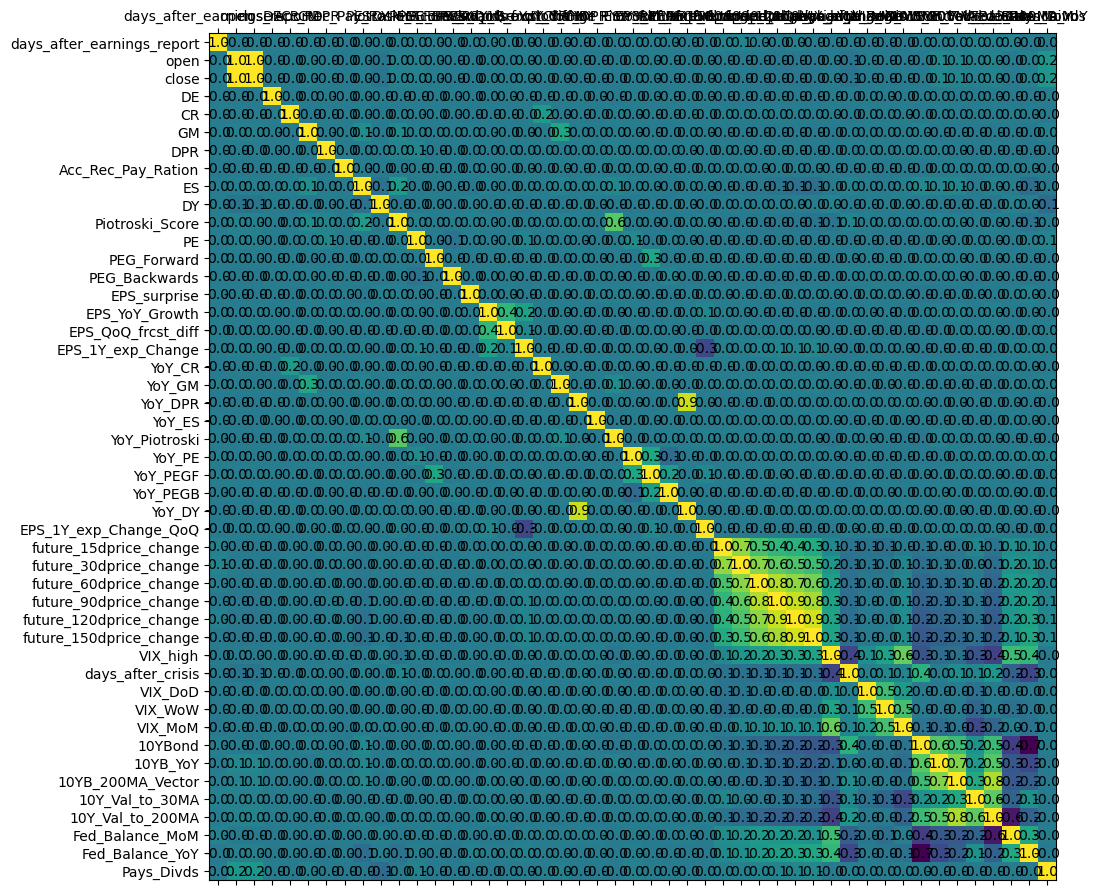

In [9]:
def plot_corr(df, size=11, method_cor = 'pearson'):
    corr = df.corr(method = method_cor)
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for (i, j), z in np.ndenumerate(corr):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
        
plot_corr(df_compact)

As we see there is no singel variable that can predict the prices movements

We can check with the Spearman method.

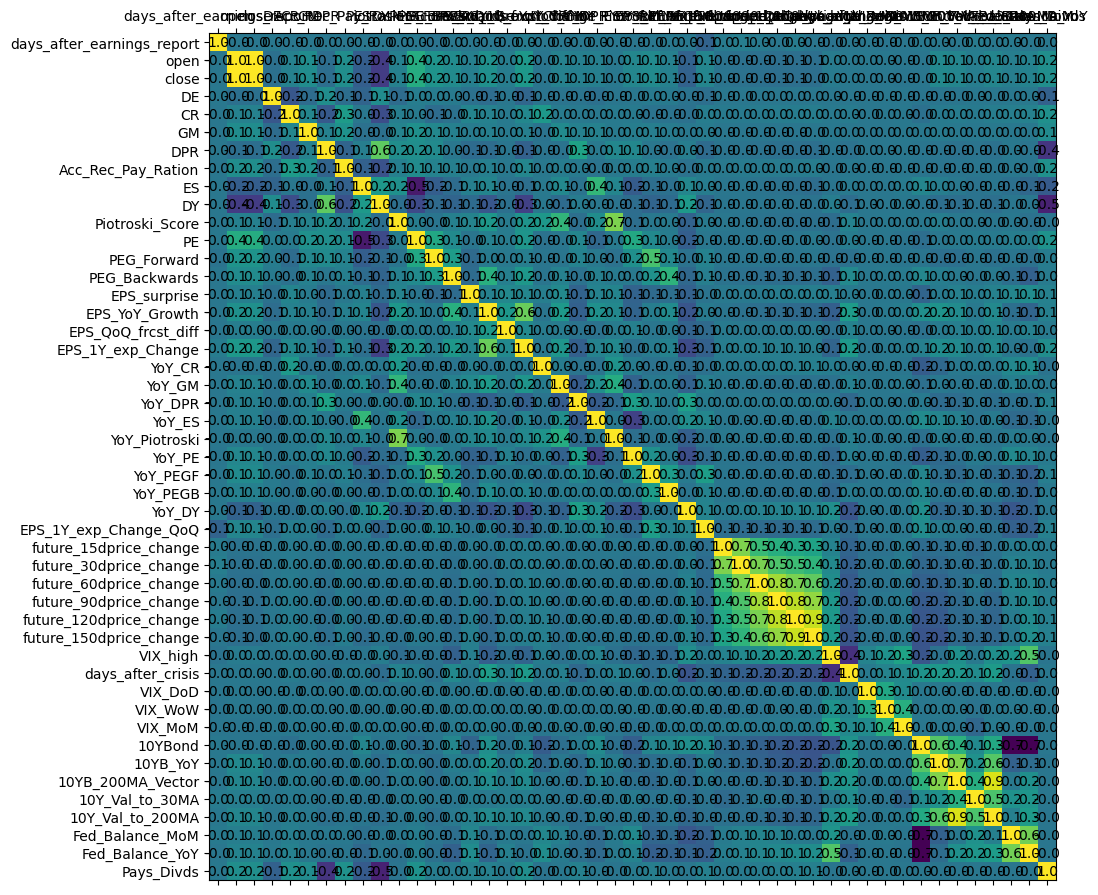

In [10]:
plot_corr(df_compact, size=11, method_cor = 'spearman')

We can see aslightly higher correlation between the variables but not with any of the targets

## Dealing with outliers

Before we change our dataset we need to split it by training and test data, so we keep the test data untouched

In [11]:
df_compact.sort_values('date', ascending = False, inplace = True)
display(df_compact.head(5))
display(df_compact.tail(5))

date  days_after_earnings_report    open   close  \
0       2023-02-24                        95.0  141.46  141.20   
90318   2023-02-24                       111.0  300.40  304.02   
446279  2023-02-24                         3.0   65.72   64.98   
88895   2023-02-24                        22.0  141.43  141.10   
447638  2023-02-24                        23.0  337.70  339.54   

                        sector  \
0                  Health Care   
90318               Financials   
446279             Real Estate   
88895   Information Technology   
447638             Industrials   

                                              industry        DE        CR  \
0       Pharmaceuticals, Biotechnology & Life Sciences  0.373805  2.106405   
90318                           Diversified Financials  0.294193  0.761186   
446279                                     Real Estate  0.488600  1.851657   
88895                              Software & Services  1.123320  1.258907   
447638                                  Transportation  0.021095  1.762462   

              GM       DPR  ...    VIX_MoM  stock  10YBond    10YB_YoY  \
0       0.551253  0.190341  ...  11.284807      A   3.9491  100.258621   
90318   0.506972 -0.821484  ...  11.284807  BRK-B   3.9491  100.258621   
446279  1.161305  5.829309  ...  11.284807      O   3.9491  100.258621   
88895   0.235672  1.480903  ...  11.284807     BR   3.9491  100.258621   
447638  2.931964  0.102010  ...  11.284807   ODFL   3.9491  100.258621   

        10YB_200MA_Vector  10Y_Val_to_30MA  10Y_Val_to_200MA  Fed_Balance_MoM  \
0                0.164146         6.681185          8.362032        -1.043225   
90318            0.164146         6.681185          8.362032        -1.043225   
446279           0.164146         6.681185          8.362032        -1.043225   
88895            0.164146         6.681185          8.362032        -1.043225   
447638           0.164146         6.681185          8.362032        -1.043225   

        Fed_Balance_YoY  Pays_Divds  
0              -6.11482         0.0  
90318          -6.11482         0.0  
446279         -6.11482         0.0  
88895          -6.11482         0.0  
447638         -6.11482         0.0  

[5 rows x 51 columns]

date  days_after_earnings_report     open    close       sector  \
328822  2016-09-16                        49.0  39.7974  39.8690  Industrials   
328823  2016-09-15                        48.0  39.8153  39.6274  Industrials   
328824  2016-09-14                        47.0  40.2001  39.8511  Industrials   
328825  2016-09-13                        46.0  40.7013  40.1375  Industrials   
328826  2016-09-12                        45.0  40.5133  41.2561  Industrials   

             industry        DE       CR        GM       DPR  ...    VIX_MoM  \
328822  Capital Goods  0.334911  0.91937  0.198298  0.409586  ...  33.802817   
328823  Capital Goods  0.334911  0.91937  0.198298  0.409586  ...  48.479869   
328824  Capital Goods  0.334911  0.91937  0.198298  0.409586  ...  51.166667   
328825  Capital Goods  0.334911  0.91937  0.198298  0.409586  ...  56.647399   
328826  Capital Goods  0.334911  0.91937  0.198298  0.409586  ...  64.080000   

        stock  10YBond   10YB_YoY  10YB_200MA_Vector  10Y_Val_to_30MA  \
328822    JCI    1.701 -23.274696          -0.011525         5.363512   
328823    JCI    1.703 -26.052974          -0.015955         5.748679   
328824    JCI    1.687 -26.041210          -0.022746         5.105710   
328825    JCI    1.734 -20.458716          -0.008861         7.937332   
328826    JCI    1.672 -24.103495          -0.007384         4.966108   

        10Y_Val_to_200MA  Fed_Balance_MoM  Fed_Balance_YoY  Pays_Divds  
328822          0.542034         0.339395        -0.137573         0.0  
328823          0.647387         0.284319        -0.137573         0.0  
328824         -0.310907         0.284319        -0.137573         0.0  
328825          2.385813        -0.213362        -0.633160         0.0  
328826         -1.242823        -0.213362        -0.633160         0.0  

[5 rows x 51 columns]

In [12]:
#dropping date as abundant variable
#df_compact.drop('date',axis = 1, inplace = True)

In [13]:
#Let's reset index to understand the earliest and the latest records
df_compact.reset_index(inplace = True)
df_compact.drop('index', axis = 1, inplace = True)

In [14]:
#df_compact_reserve = df_compact.copy()
display(df_compact.head(5))

date  days_after_earnings_report    open   close  \
0  2023-02-24                        95.0  141.46  141.20   
1  2023-02-24                       111.0  300.40  304.02   
2  2023-02-24                         3.0   65.72   64.98   
3  2023-02-24                        22.0  141.43  141.10   
4  2023-02-24                        23.0  337.70  339.54   

                   sector                                        industry  \
0             Health Care  Pharmaceuticals, Biotechnology & Life Sciences   
1              Financials                          Diversified Financials   
2             Real Estate                                     Real Estate   
3  Information Technology                             Software & Services   
4             Industrials                                  Transportation   

         DE        CR        GM       DPR  ...    VIX_MoM  stock  10YBond  \
0  0.373805  2.106405  0.551253  0.190341  ...  11.284807      A   3.9491   
1  0.294193  0.761186  0.506972 -0.821484  ...  11.284807  BRK-B   3.9491   
2  0.488600  1.851657  1.161305  5.829309  ...  11.284807      O   3.9491   
3  1.123320  1.258907  0.235672  1.480903  ...  11.284807     BR   3.9491   
4  0.021095  1.762462  2.931964  0.102010  ...  11.284807   ODFL   3.9491   

     10YB_YoY  10YB_200MA_Vector  10Y_Val_to_30MA  10Y_Val_to_200MA  \
0  100.258621           0.164146         6.681185          8.362032   
1  100.258621           0.164146         6.681185          8.362032   
2  100.258621           0.164146         6.681185          8.362032   
3  100.258621           0.164146         6.681185          8.362032   
4  100.258621           0.164146         6.681185          8.362032   

   Fed_Balance_MoM  Fed_Balance_YoY  Pays_Divds  
0        -1.043225         -6.11482         0.0  
1        -1.043225         -6.11482         0.0  
2        -1.043225         -6.11482         0.0  
3        -1.043225         -6.11482         0.0  
4        -1.043225         -6.11482         0.0  

[5 rows x 51 columns]

In [15]:
cols_num = df_compact.select_dtypes([np.number]).columns
cols_str = df_compact.select_dtypes('object').columns

df_compact[cols_num].describe().T

count          mean           std  \
days_after_earnings_report  648488.0     45.569687  2.754035e+01   
open                        648488.0    143.141598  2.387538e+02   
close                       648488.0    143.148872  2.388162e+02   
DE                          648488.0      0.992124  1.770509e+02   
CR                          648488.0   1585.960073  1.096883e+05   
GM                          648488.0      0.439581  1.183801e+00   
DPR                         648488.0      0.278797  2.918901e+01   
Acc_Rec_Pay_Ration          648488.0    186.623216  1.827563e+04   
ES                          648488.0      0.957217  3.757523e+00   
DY                          648488.0      2.420557  6.293345e+00   
Piotroski_Score             648488.0      6.346881  1.343416e+00   
PE                          648488.0     24.649503  8.109918e+01   
PEG_Forward                 648488.0      0.870823  2.764736e+01   
PEG_Backwards               648488.0      0.782353  1.696131e+01   
EPS_surprise                648488.0     10.443325  2.022560e+02   
EPS_YoY_Growth              648488.0     15.792475  4.998528e+02   
EPS_QoQ_frcst_diff          648488.0     -0.133030  3.215982e+02   
EPS_1Y_exp_Change           648488.0     38.147877  4.642338e+02   
YoY_CR                      648488.0  40252.323845  1.190063e+07   
YoY_GM                      648488.0      0.353150  9.412232e+02   
YoY_DPR                     648488.0   2753.777122  1.399514e+05   
YoY_ES                      648488.0     49.199307  3.926052e+03   
YoY_Piotroski               648488.0      4.478769  3.802776e+01   
YoY_PE                      648488.0     24.433814  2.285113e+03   
YoY_PEGF                    648488.0    -18.348735  3.418051e+03   
YoY_PEGB                    648488.0     51.899073  1.361613e+04   
YoY_DY                      648488.0   4166.238325  1.680012e+05   
EPS_1Y_exp_Change_QoQ       648488.0     10.159686  7.321311e+02   
future_15dprice_change      643645.0      0.622613  7.371548e+00   
future_30dprice_change      638215.0      1.245024  1.029662e+01   
future_60dprice_change      627369.0      2.350809  1.421338e+01   
future_90dprice_change      616544.0      3.407940  1.713033e+01   
future_120dprice_change     605720.0      4.427648  2.013530e+01   
future_150dprice_change     594931.0      5.383617  2.279354e+01   
VIX_high                    648488.0     22.321723  9.365479e+00   
days_after_crisis           648488.0   1047.187229  1.427154e+03   
VIX_DoD                     648488.0      0.435699  9.159225e+00   
VIX_WoW                     648488.0      2.105862  2.158940e+01   
VIX_MoM                     648488.0      7.423530  5.000212e+01   
10YBond                     648488.0      2.116693  9.189227e-01   
10YB_YoY                    648488.0     28.550563  7.016188e+01   
10YB_200MA_Vector           648488.0      0.025793  2.354734e-01   
10Y_Val_to_30MA             648488.0     -0.062468  9.316319e+00   
10Y_Val_to_200MA            648488.0     -2.834429  3.263583e+01   
Fed_Balance_MoM             648488.0      1.120671  5.235329e+00   
Fed_Balance_YoY             648488.0     16.807500  3.078043e+01   
Pays_Divds                  648488.0      0.091443  2.882390e-01   

                                     min         25%         50%         75%  \
days_after_earnings_report  0.000000e+00   21.000000   45.000000   69.000000   
open                        1.900000e+00   52.910000   92.060000  163.730000   
close                       1.940000e+00   52.900000   92.070000  163.700000   
DE                         -7.698717e+02    0.201620    0.419925    0.707265   
CR                         -1.272126e+02    0.943819    1.376096    2.213906   
GM                         -6.379194e+01    0.294312    0.436848    0.644687   
DPR                        -2.410406e+03    0.063143    0.297902    0.561313   
Acc_Rec_Pay_Ration         -1.739130e+00    0.834917    1.604805    3.124264   
ES                         -1.906603e+02    0.

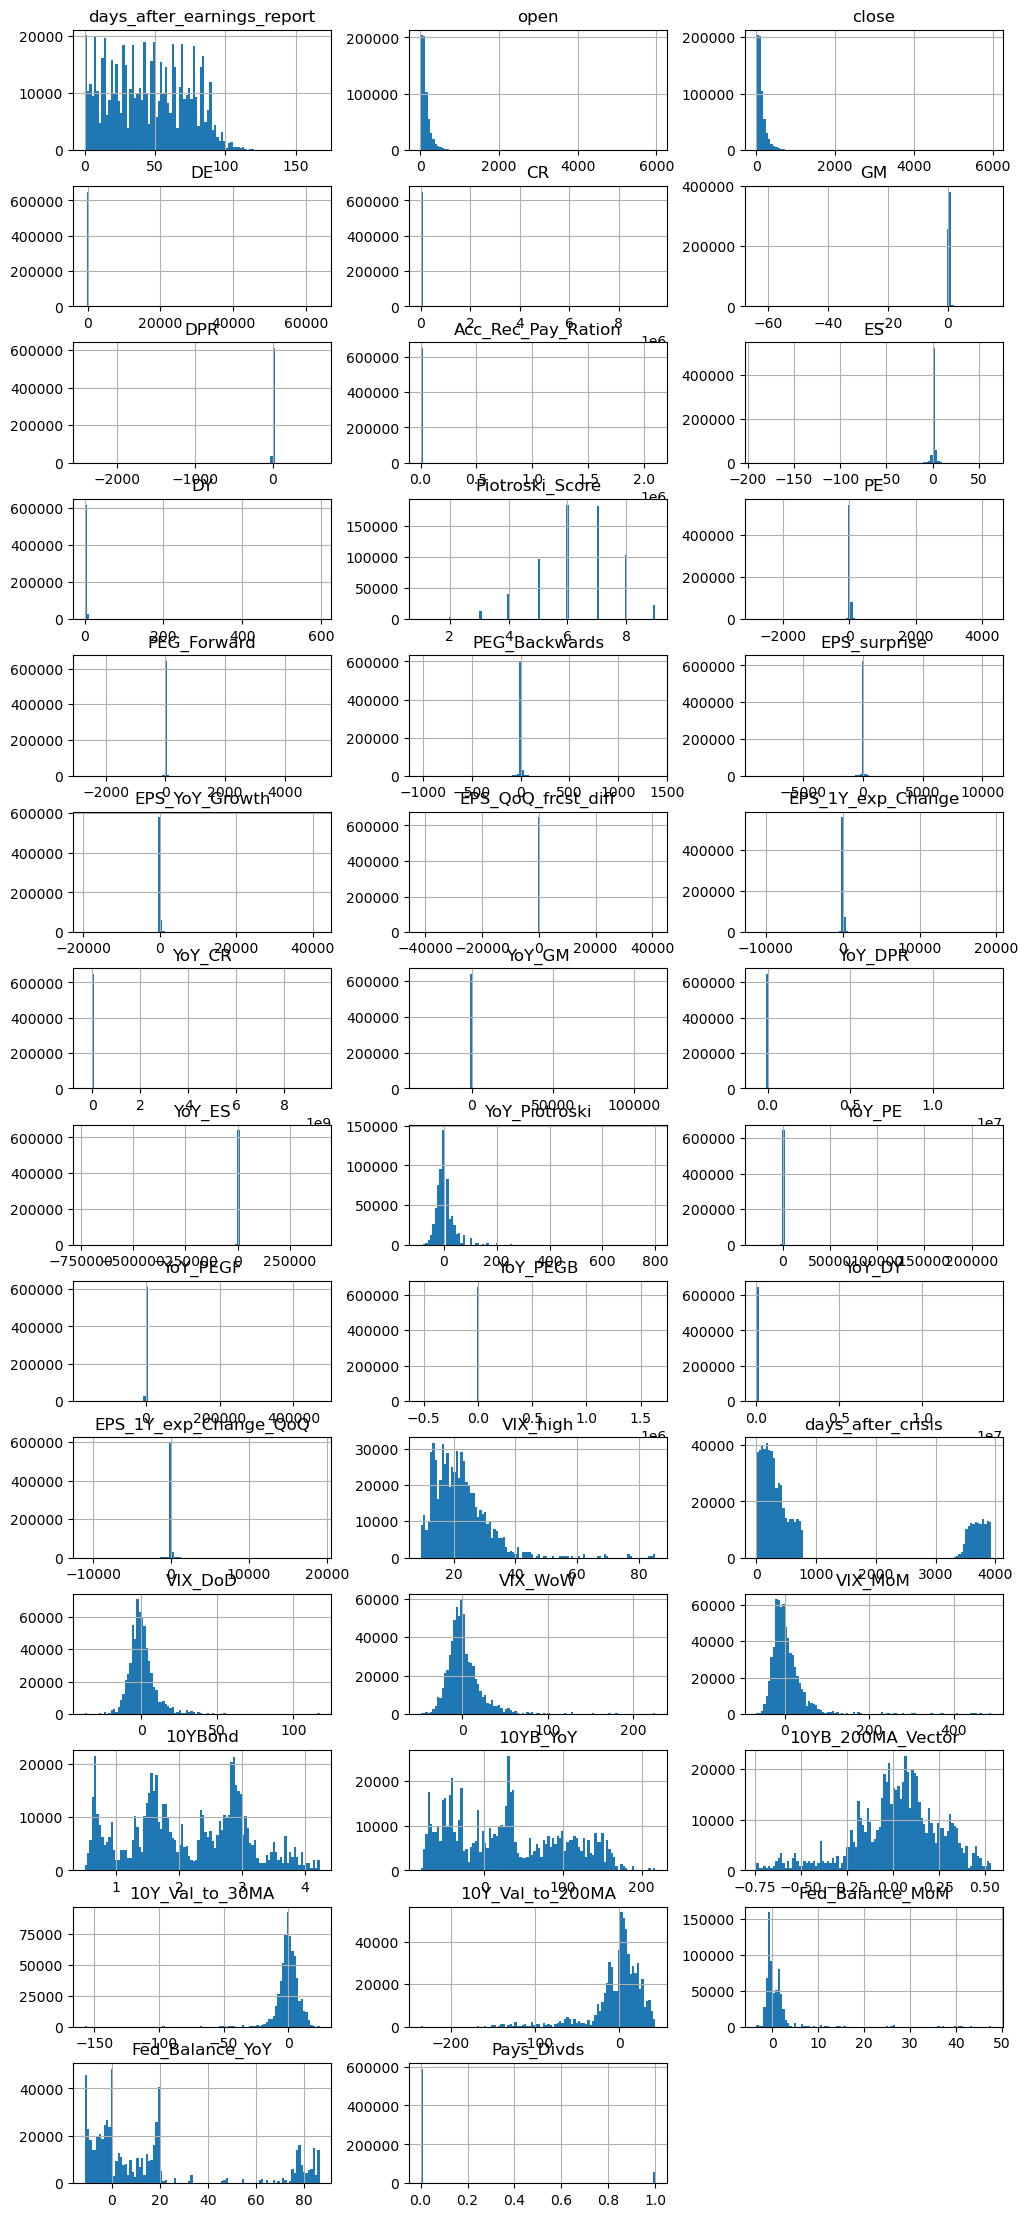

In [16]:
target_vars = ["future_15dprice_change", "future_30dprice_change", "future_60dprice_change", "future_90dprice_change", "future_120dprice_change", "future_150dprice_change"]
cols_num_no_targets = [x for x in cols_num if x not in target_vars]
df_compact[cols_num_no_targets].hist(stacked=False, bins=100, figsize=(12,30), layout=(15,3));

#### There are many outliers we would need to treat.

#### Let's replace outliers with 3 st.dev values to normalize our data a little

 Now we need to select columns that we want to "treat".
 We need only columns with wide values distribution that looks like a normal distribution:

In [17]:
columns_to_trim = ['DE',
                     'CR',
                     'GM',
                     'DPR',
                     'Acc_Rec_Pay_Ration',
                     'ES',
                     'DY',
                     'PE',
                     'PEG_Forward',
                     'PEG_Backwards',
                     'EPS_surprise',
                     'EPS_YoY_Growth',
                     'EPS_QoQ_frcst_diff',
                     'EPS_1Y_exp_Change',
                     'YoY_CR',
                     'YoY_GM',
                     'YoY_DPR',
                     'YoY_ES',
                     'YoY_Piotroski',
                     'YoY_PE',
                     'YoY_PEGF',
                     'YoY_PEGB',
                    '10Y_Val_to_30MA',
                     '10Y_Val_to_200MA',
                     'YoY_DY'  ]

In [18]:
#Removing All above 3 std

def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        mean = df[col].mean()
        sd = df[col].std()
        df = df[(df[col] <= mean+(n_std*sd))]  
    return df

df_compact = remove_outliers(df_compact, columns_to_trim, 2)

Working on column: DE
Working on column: CR
Working on column: GM
Working on column: DPR
Working on column: Acc_Rec_Pay_Ration
Working on column: ES
Working on column: DY
Working on column: PE
Working on column: PEG_Forward
Working on column: PEG_Backwards
Working on column: EPS_surprise
Working on column: EPS_YoY_Growth
Working on column: EPS_QoQ_frcst_diff
Working on column: EPS_1Y_exp_Change
Working on column: YoY_CR
Working on column: YoY_GM
Working on column: YoY_DPR
Working on column: YoY_ES
Working on column: YoY_Piotroski
Working on column: YoY_PE
Working on column: YoY_PEGF
Working on column: YoY_PEGB
Working on column: 10Y_Val_to_30MA
Working on column: 10Y_Val_to_200MA
Working on column: YoY_DY


In [19]:
df_compact.shape

(580368, 51)

In [20]:
replace_outliers = ['DE',
                     'CR',
                     'GM',
                     'DPR',
                     'Acc_Rec_Pay_Ration',
                     'ES',
                     'PE',
                     'PEG_Forward',
                     'PEG_Backwards',
                     'EPS_surprise',
                     'EPS_YoY_Growth',
                     'EPS_QoQ_frcst_diff',
                     'EPS_1Y_exp_Change',
                     'YoY_CR',
                     'YoY_GM',
                     'YoY_DPR',
                     'YoY_ES',
                     'YoY_Piotroski',
                     'YoY_PE',
                     'YoY_PEGF',
                     'YoY_PEGB',
                    '10Y_Val_to_30MA',
                     '10Y_Val_to_200MA',
                     'YoY_DY'  ]

In [21]:
# Replacing all above 2 std to 2 std value
def replace_train(group):
    mean, std = group.mean(), group.std()
    outliers_max = (group - mean) > 2*std
    outliers_min = (mean - group) > 2*std
    #outliers = (group - mean).abs() > 3*std
    group[outliers_max] = mean + 2*std    
    group[outliers_min] = mean - 2*std    
    return group


df_compact[columns_to_trim] = df_compact[columns_to_trim].transform(replace_train)

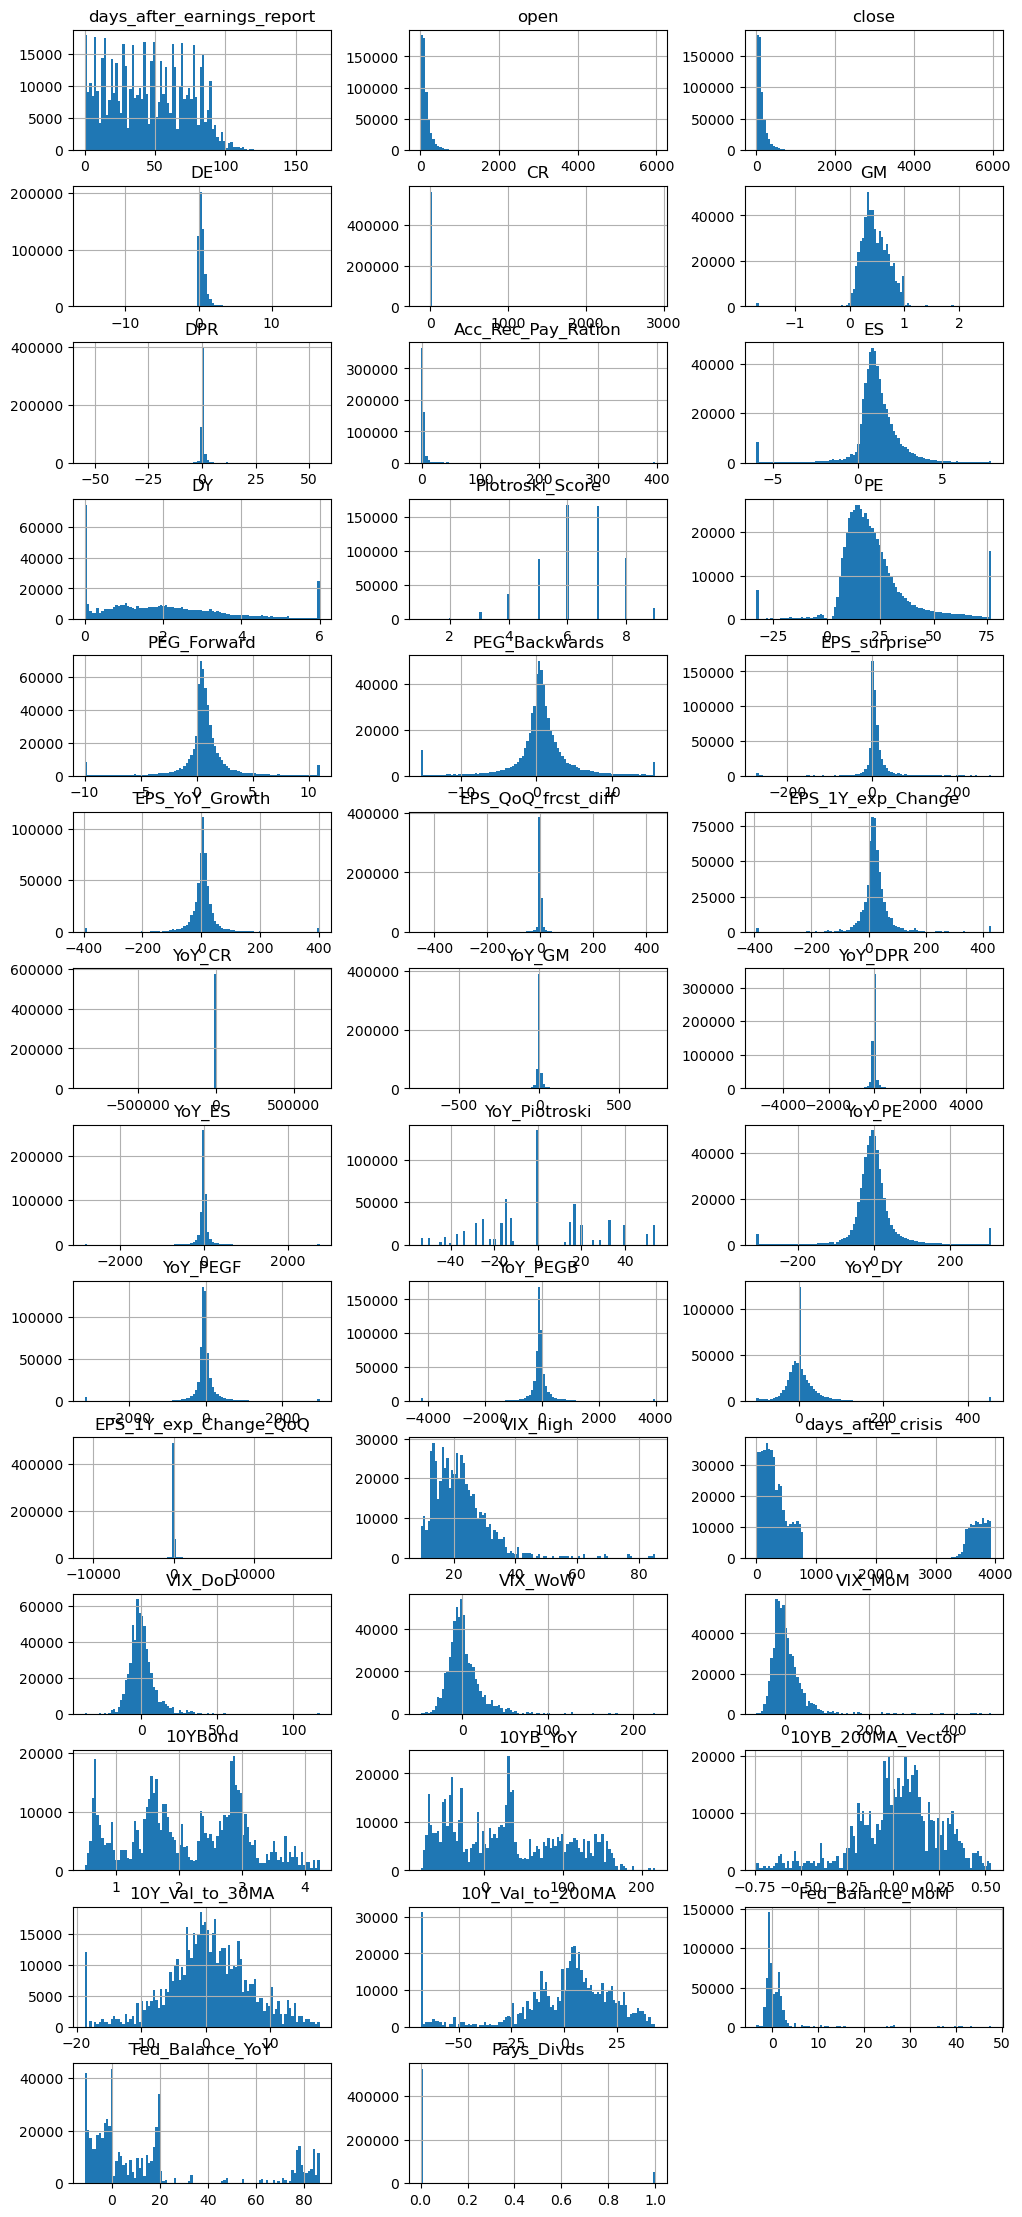

In [22]:
df_compact[cols_num_no_targets].hist(stacked=False, bins=100, figsize=(12,30), layout=(15,3));

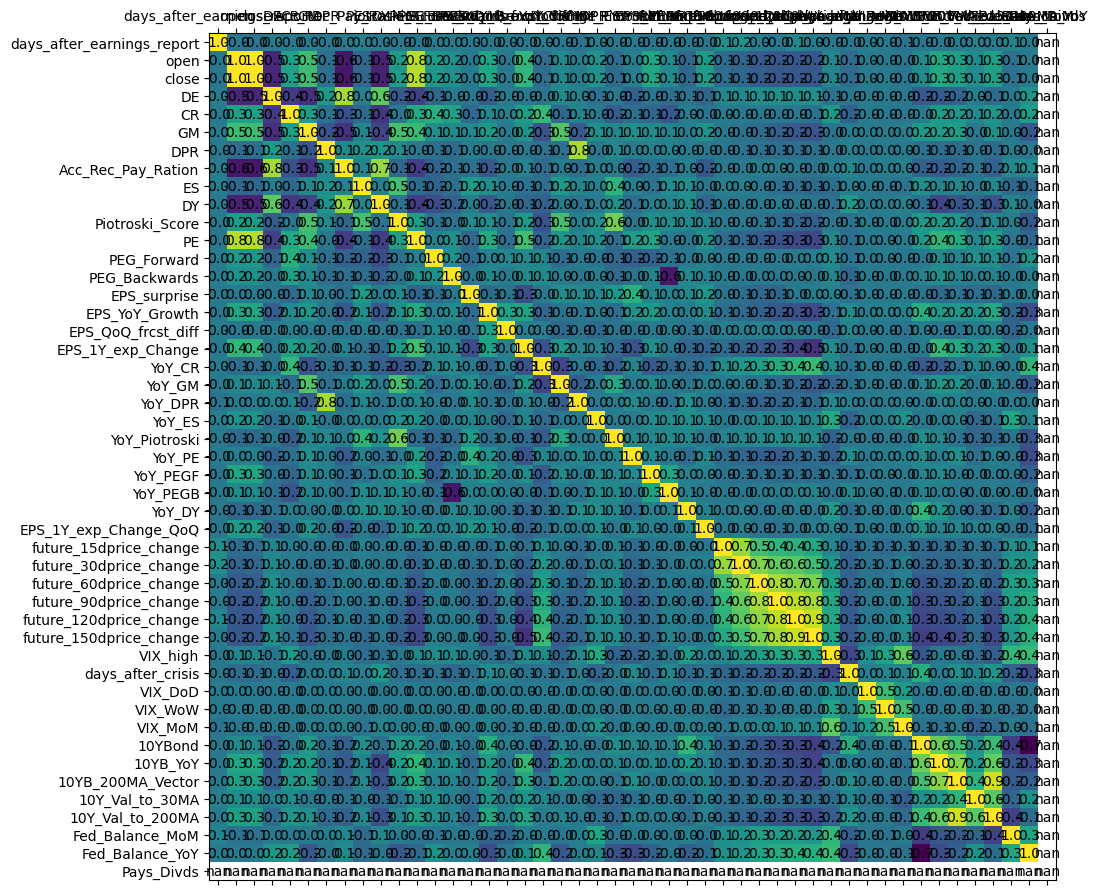

In [23]:
plot_corr(df_compact[(df_compact['Pays_Divds'] == 0) & (df_compact['industry'] == 'Automobiles & Components')])#, size=11, method_cor = 'spearman')

In [24]:
df_compact[(df_compact['Pays_Divds'] == 1) & (df_compact['industry'] == 'Automobiles & Components')]['DPR'].unique()

array([0.])

## Categorical Data

In [25]:
#df_train = train_dfs_list[0]
#df_train[["sector","stock"]].groupby("sector").nunique()
df_compact[["industry","stock"]].groupby("industry").nunique()

stock
industry                                             
Automobiles & Components                            5
Banks                                              18
Capital Goods                                      48
Commercial & Professional Services                  9
Consumer Durables & Apparel                        13
Consumer Services                                  15
Diversified Financials                             26
Energy                                             23
Food & Staples Retailing                            4
Food, Beverage & Tobacco                           22
Health Care Equipment & Services                   36
Household & Personal Products                       6
Insurance                                          23
Materials                                          29
Media & Entertainment                              20
Pharmaceuticals, Biotechnology & Life Sciences     27
Real Estate                                        28
Retailing                                          23
Semiconductors & Semiconductor Equipment           21
Software & Services                                33
Technology Hardware & Equipment                    17
Telecommunication Services                          4
Transportation                                     14
Utilities                                          30

In [26]:
#df_train.groupby("sector").mean().style.highlight_max(color='green').highlight_min(color='red')
df_compact.groupby("industry").mean().style.highlight_max(color='green').highlight_min(color='red')

I commented the next  cells out to avoid any data removal as boosting techniques do not require that

In [31]:
df_compact.describe()

days_after_earnings_report           open          close  \
count               648488.000000  648488.000000  648488.000000   
mean                    45.569687     143.141598     143.148872   
std                     27.540354     238.753774     238.816221   
min                      0.000000       1.900000       1.940000   
25%                     21.000000      52.910000      52.900000   
50%                     45.000000      92.060000      92.070000   
75%                     69.000000     163.730000     163.700000   
max                    167.000000    5977.609900    5959.330100   

                 ROE           LTDE             DE            CR  \
count  648488.000000  648488.000000  648488.000000  6.484880e+05   
mean        0.053745       0.923035       0.992124  1.585960e+03   
std        11.060116     177.031740     177.050947  1.096883e+05   
min      -186.250000    -754.825221    -769.871681 -1.272126e+02   
25%         0.005815       0.157213       0.201620  9.438191e-01   
50%         0.014677       0.360569       0.419925  1.376096e+00   
75%         0.028060       0.616404       0.707265  2.213906e+00   
max      3973.964106   63680.113606   63680.129944  9.490595e+06   

                  GM            ROA            DPR  ...        10YBond  \
count  648488.000000  648488.000000  648488.000000  ...  648488.000000   
mean        0.439581       0.053745       0.278797  ...       2.116693   
std         1.183801      11.060116      29.189007  ...       0.918923   
min       -63.791935    -186.250000   -2410.405797  ...       0.498000   
25%         0.294312       0.005815       0.063143  ...       1.468000   
50%         0.436848       0.014677       0.297902  ...       2.050000   
75%         0.644687       0.028060       0.561313  ...       2.863000   
max        14.464646    3973.964106     602.380952  ...       4.232000   

            10YB_MoM       10YB_YoY  10YB_30MA_Vector  10YB_200MA_Vector  \
count  648488.000000  648488.000000     648488.000000      648488.000000   
mean        1.852668      28.550563          0.028959           0.025793   
std        13.713859      70.161882          0.476466           0.235473   
min       -68.421053     -81.064639         -2.729227          -0.742576   
25%        -5.167249     -37.262795         -0.175084          -0.091981   
50%         1.116561      24.915825          0.036555           0.045253   
75%         9.286723      87.921760          0.298614           0.172140   
max        53.413655     217.529880          1.324854           0.536144   

       10Y_Val_to_30MA  10Y_Val_to_200MA  Fed_Balance_MoM  Fed_Balance_YoY  \
count    648488.000000     648488.000000    648488.000000    648488.000000   
mean         -0.062468         -2.834429         1.120671        16.807500   
std           9.316319         32.635833         5.235329        30.780433   
min        -157.402945       -236.256225        -3.462438       -11.266272   
25%          -3.380248        -10.568678        -0.744793        -4.148001   
50%           0.384039          4.072720        -0.073897         3.485585   
75%           4.575084         15.693919         1.309530        19.436842   
max          24.250460         43.226721        47.681318        86.560603   

          Pays_Divds  
count  648488.000000  
mean        0.091443  
std         0.288239  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 59 columns]

In [ ]:
    max_roe = 30
    min_roe =  0
    max_ltde = 2
    min_ltde = -2
    max_de = 10
    min_de = -2
    max_cr = -5
    min_cr = 5
    max_gm = -5
    min_gm = 5

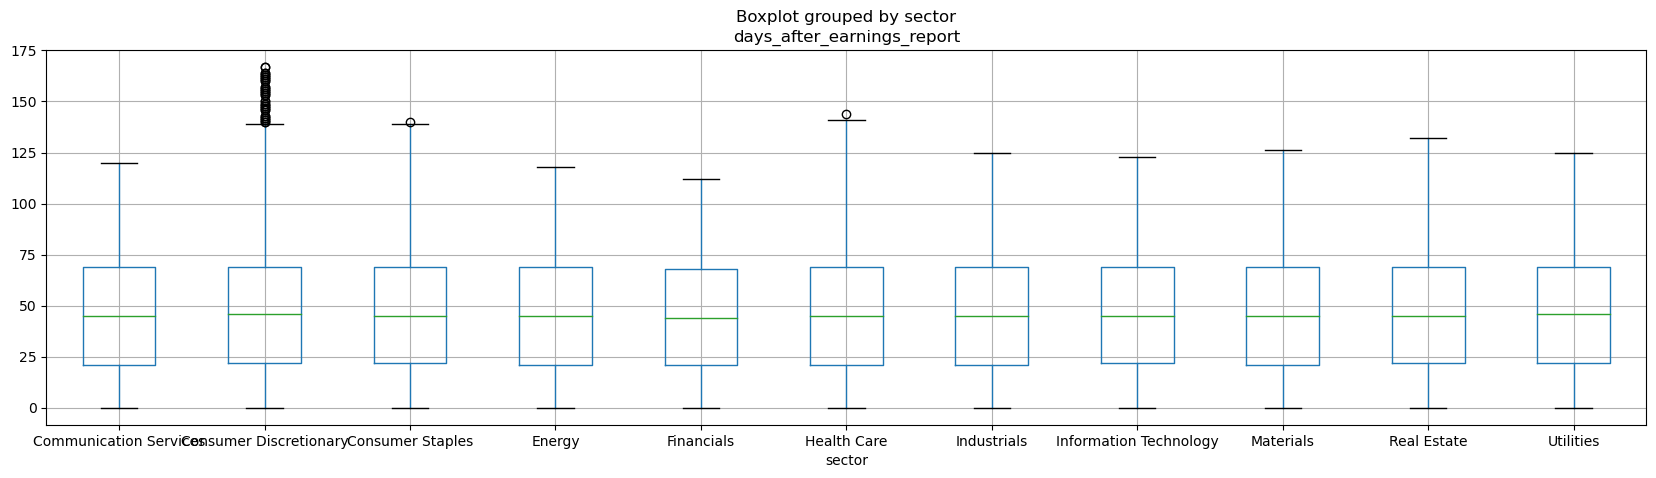

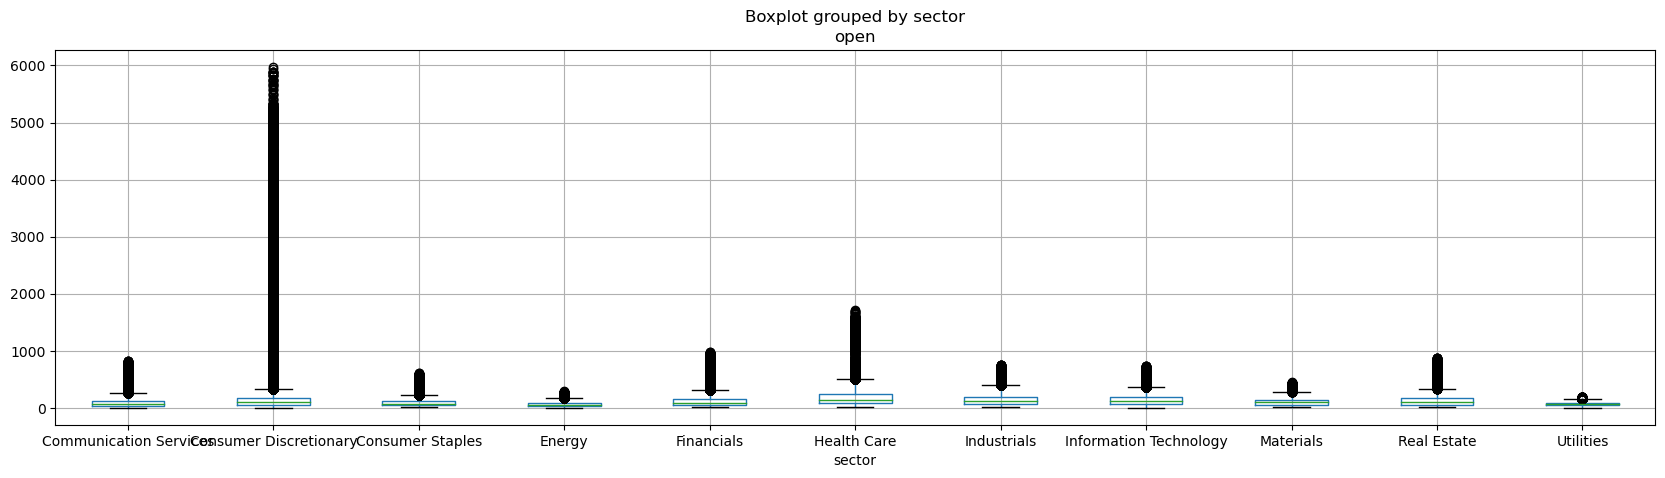

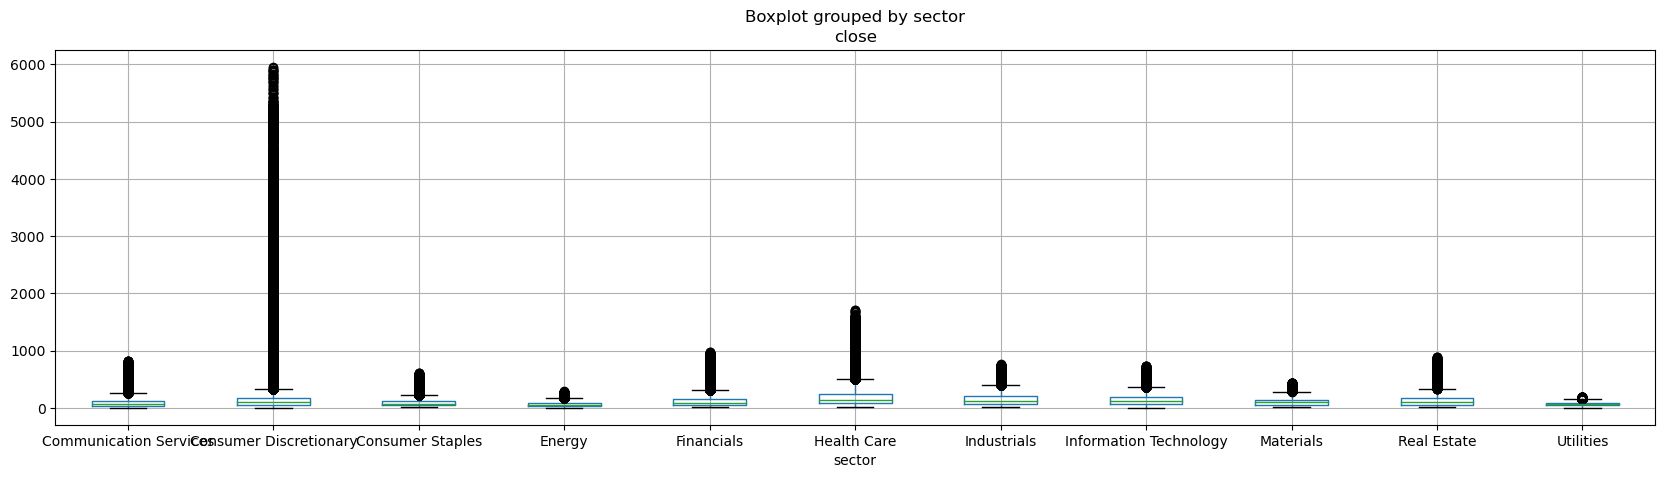

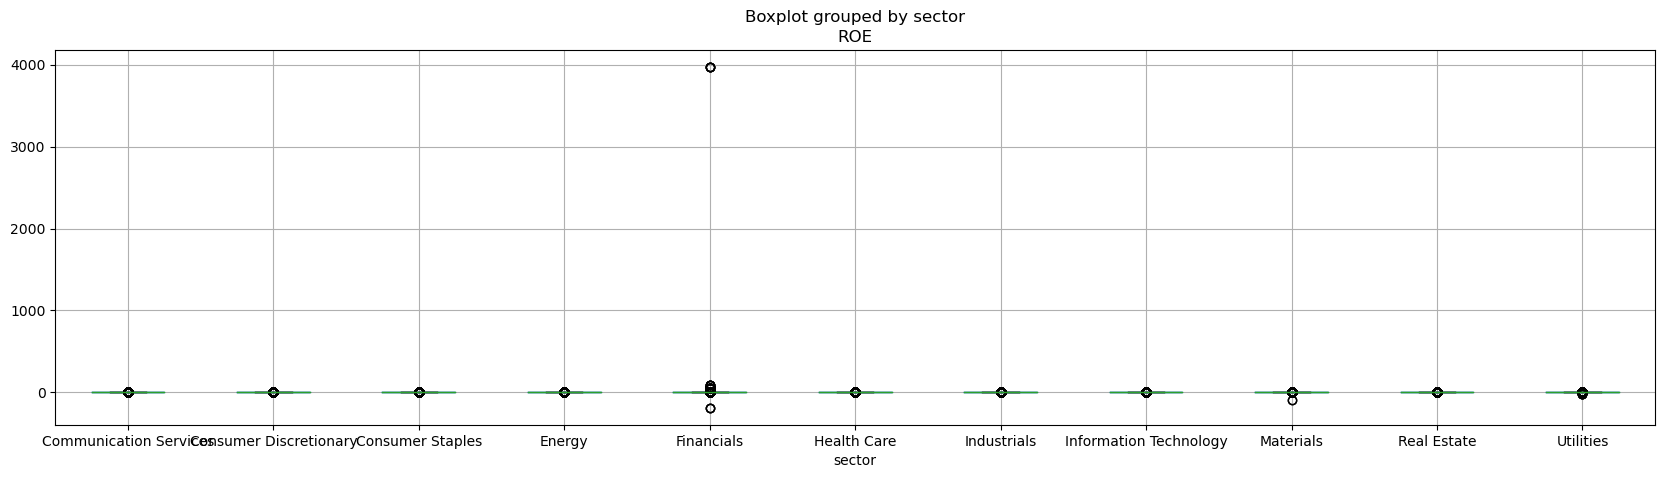

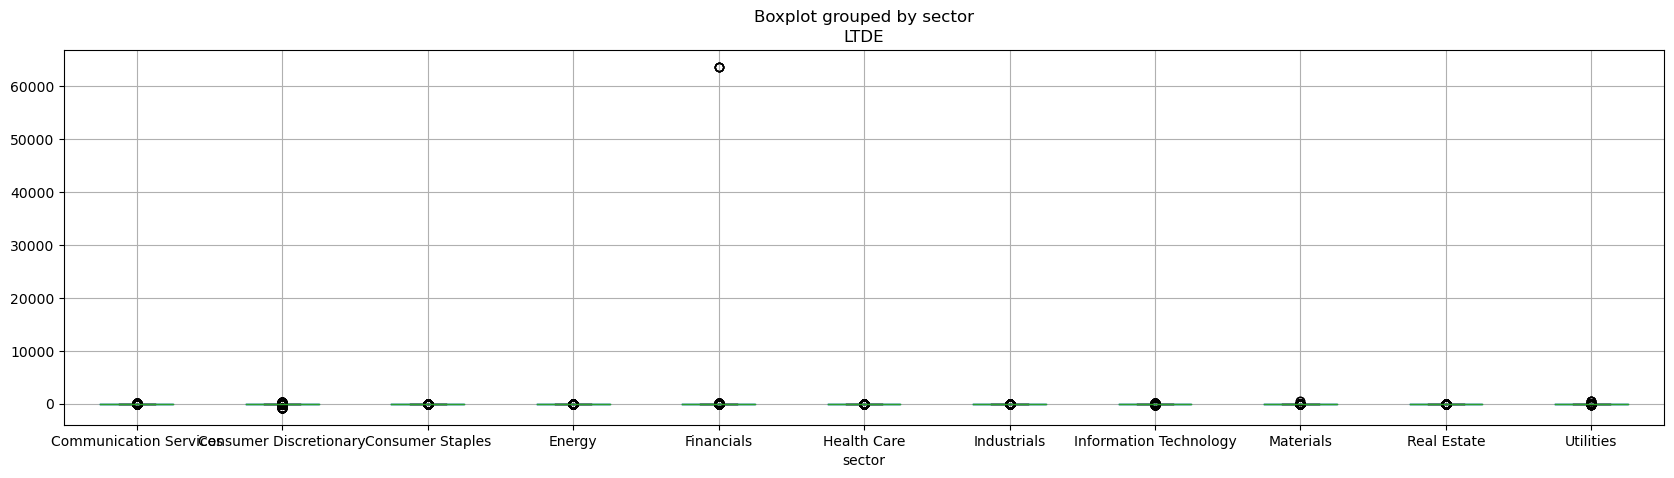

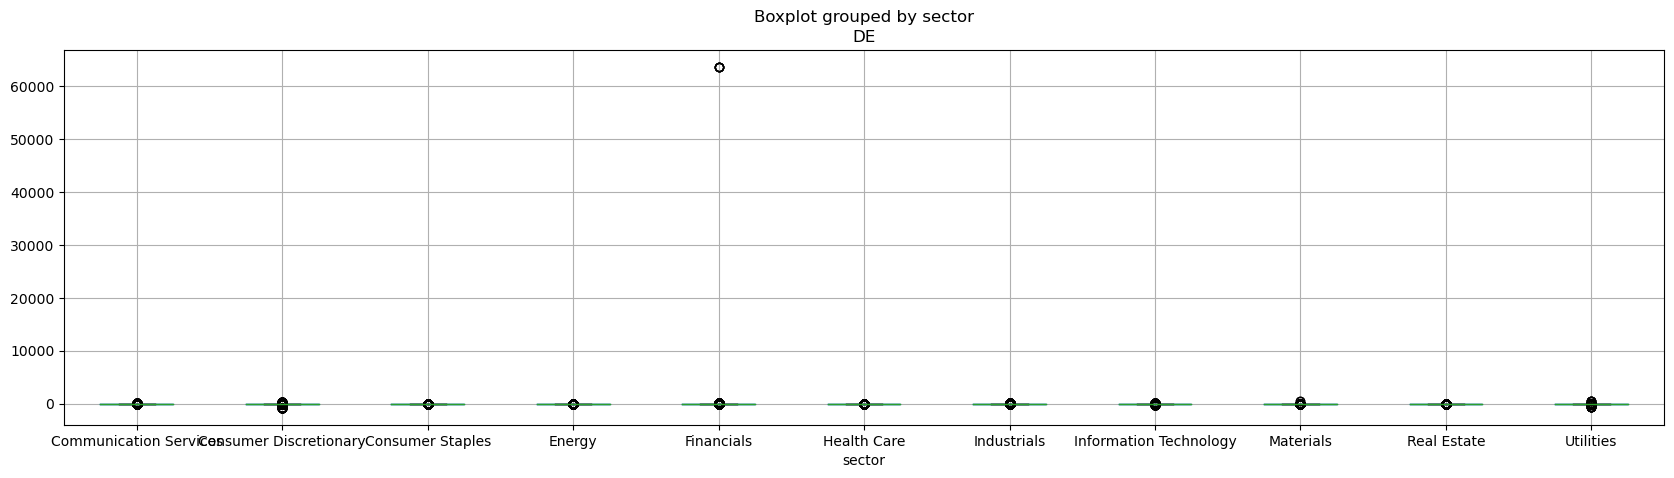

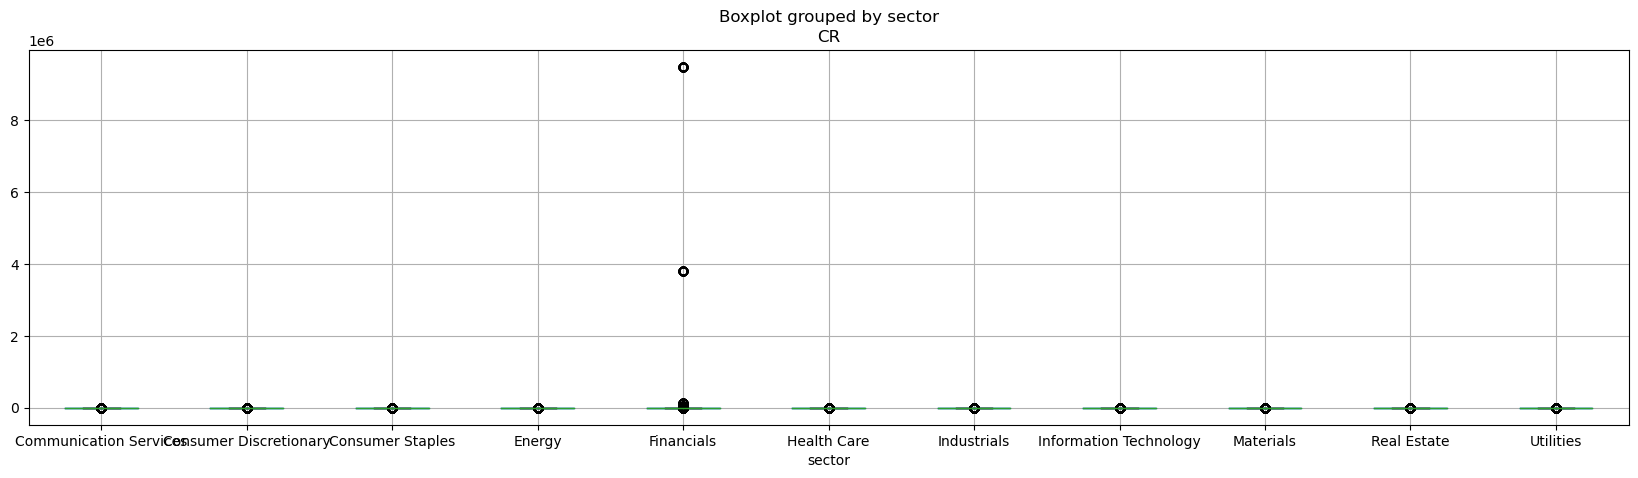

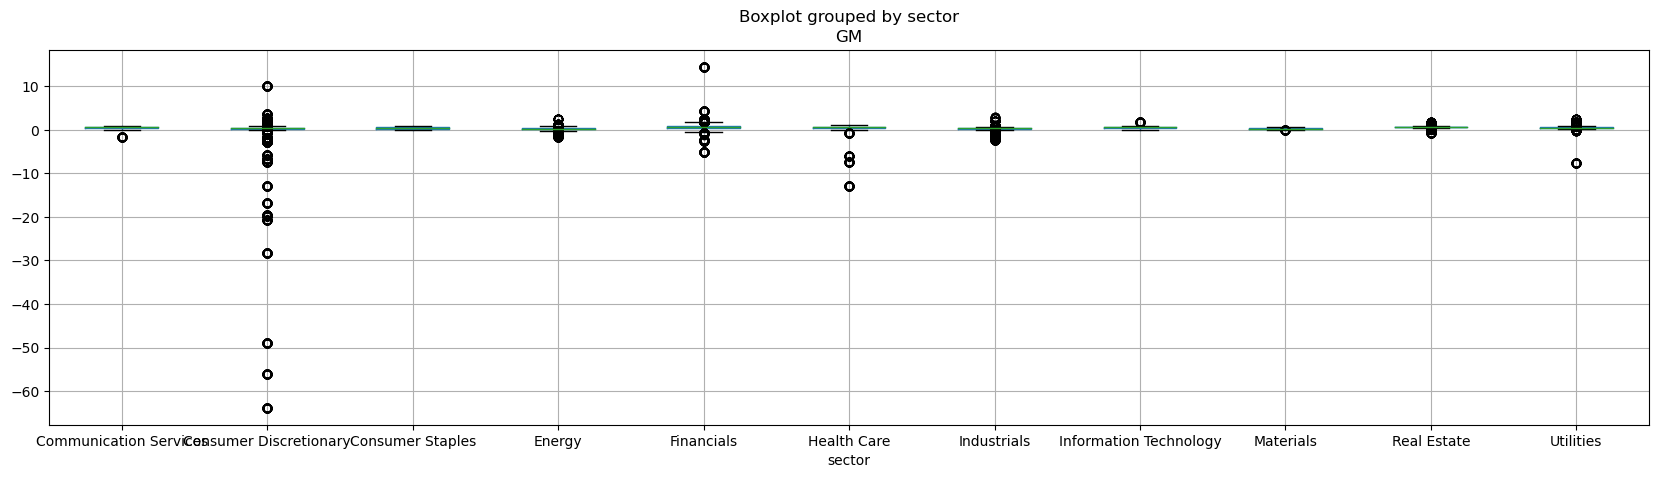

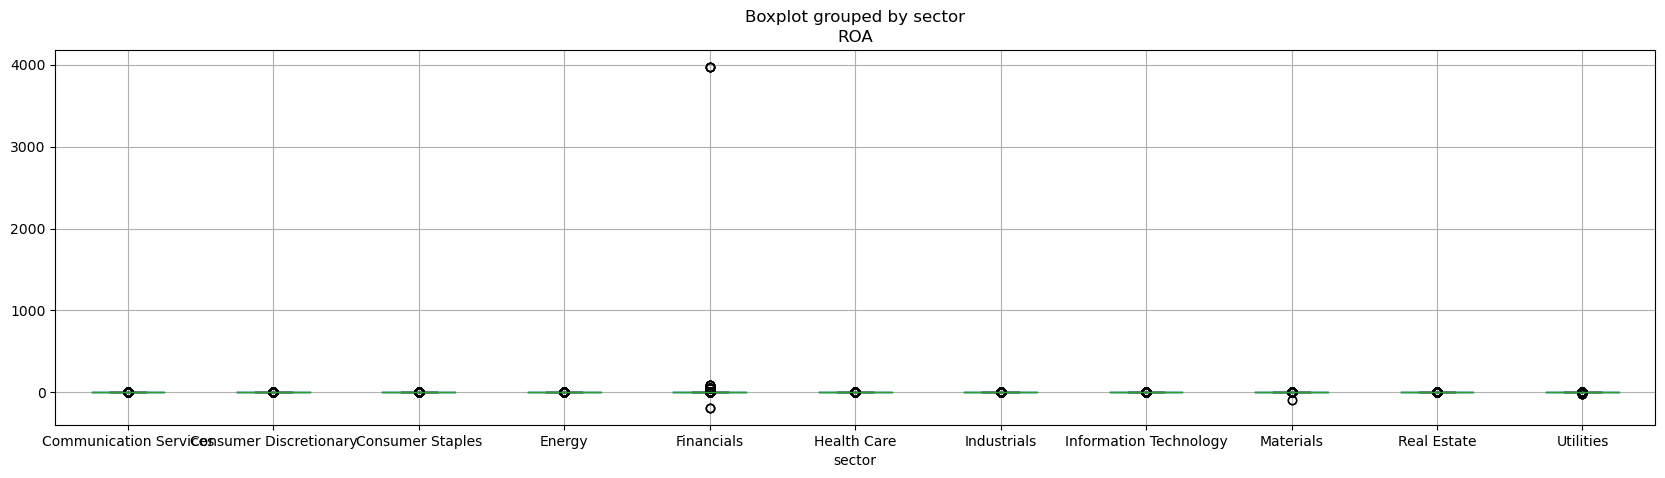

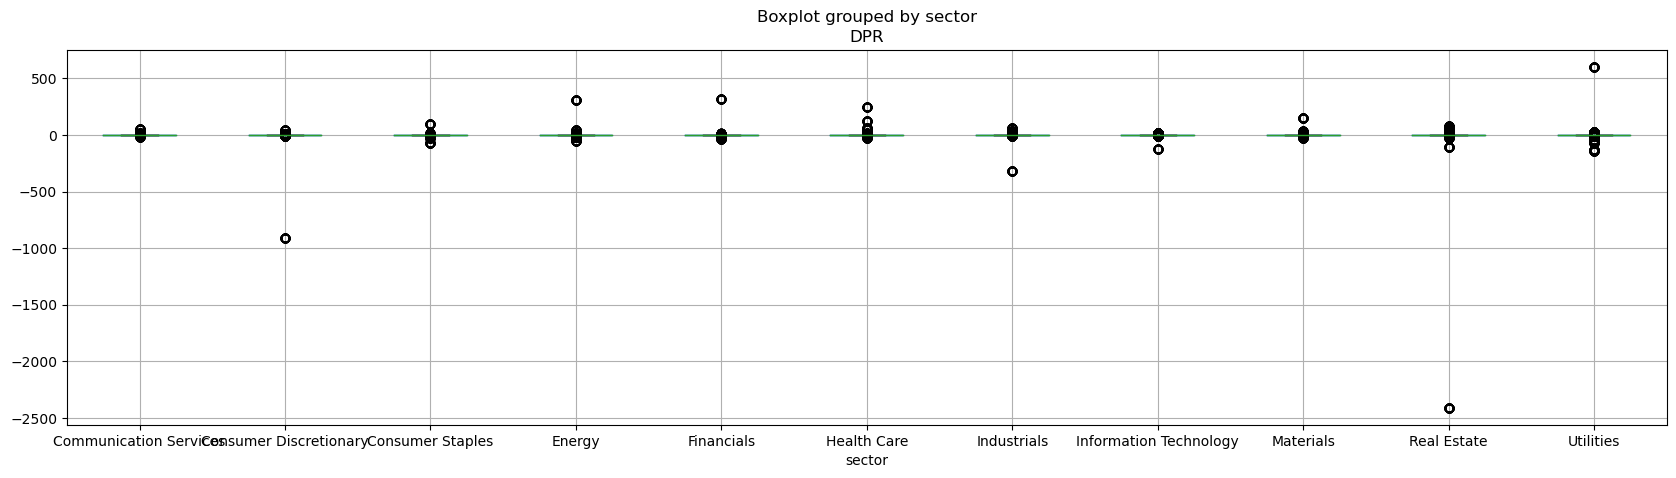

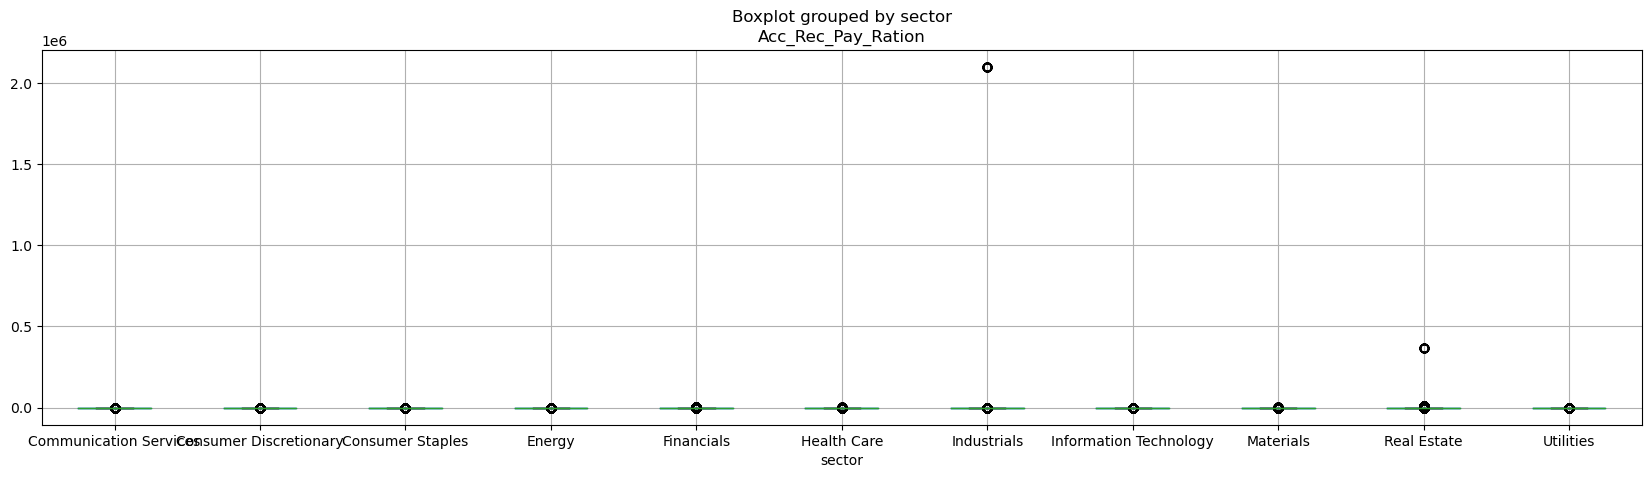

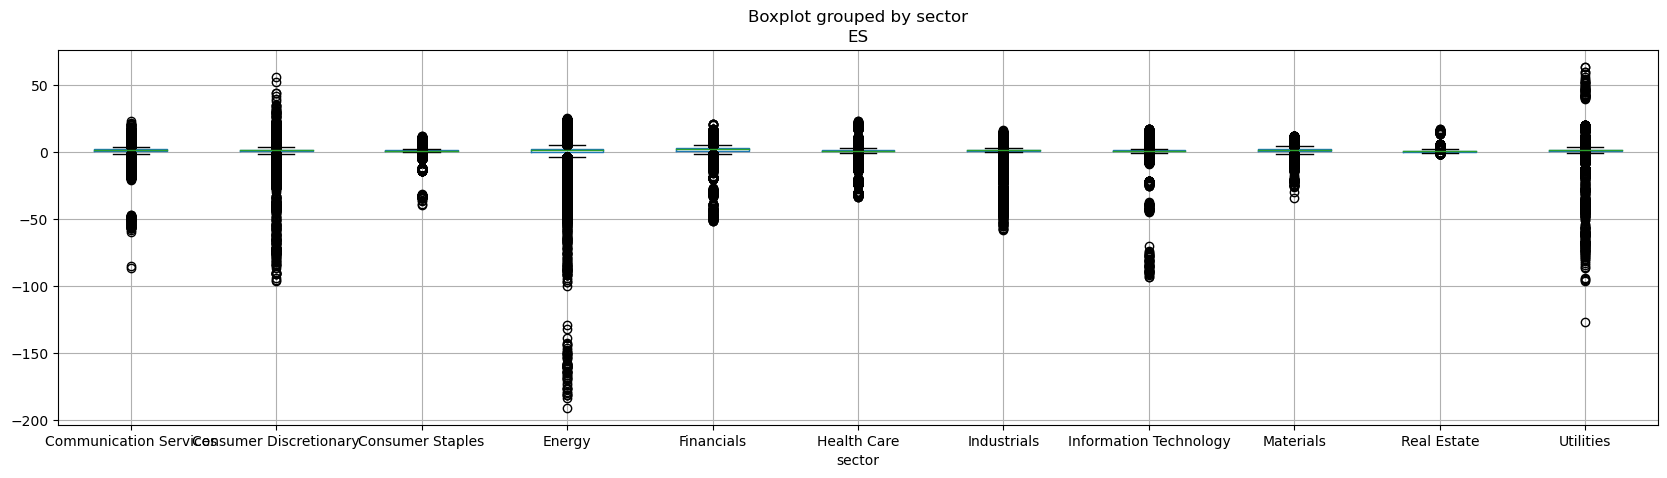

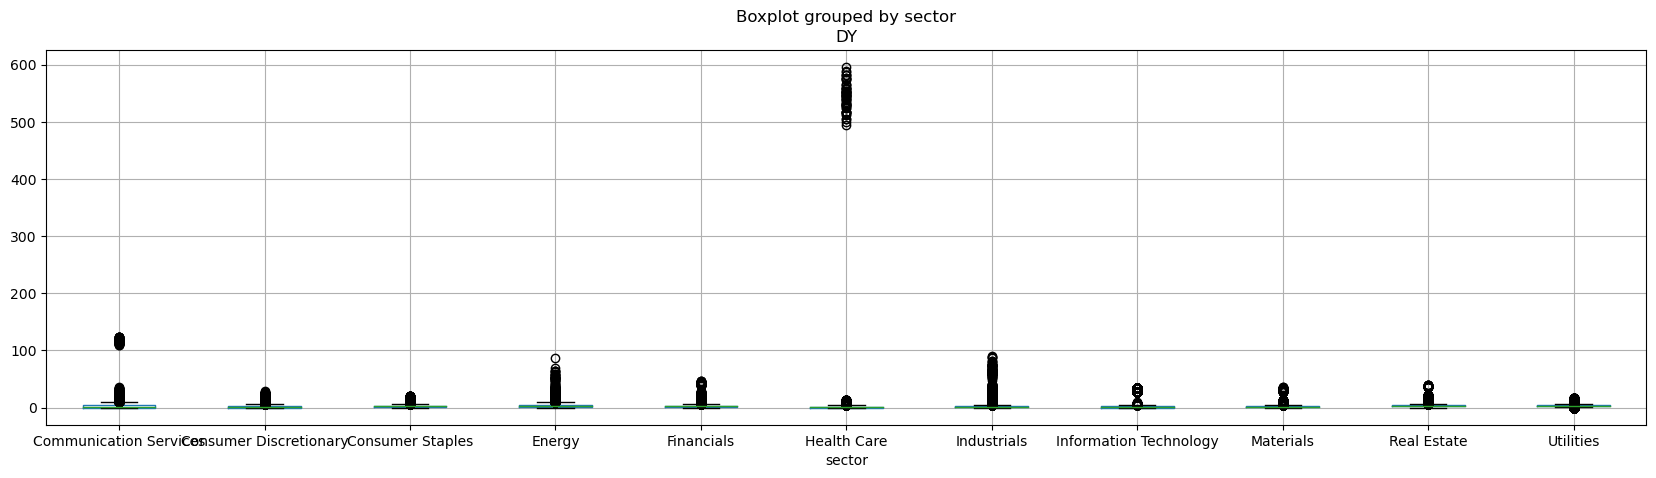

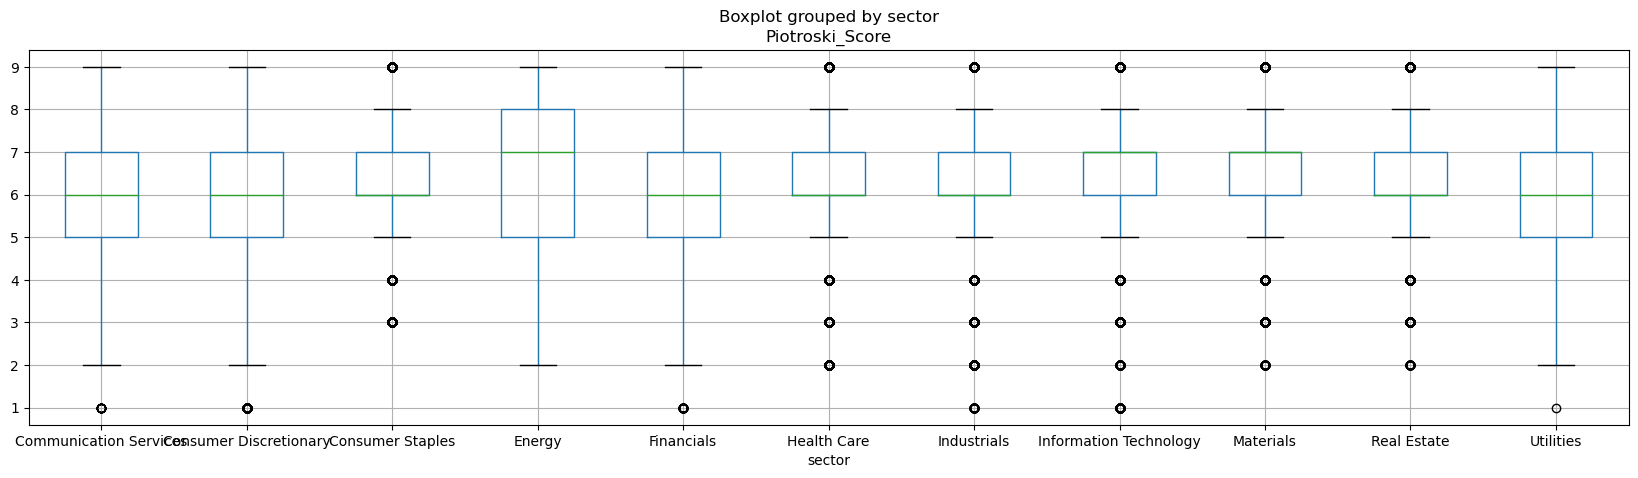

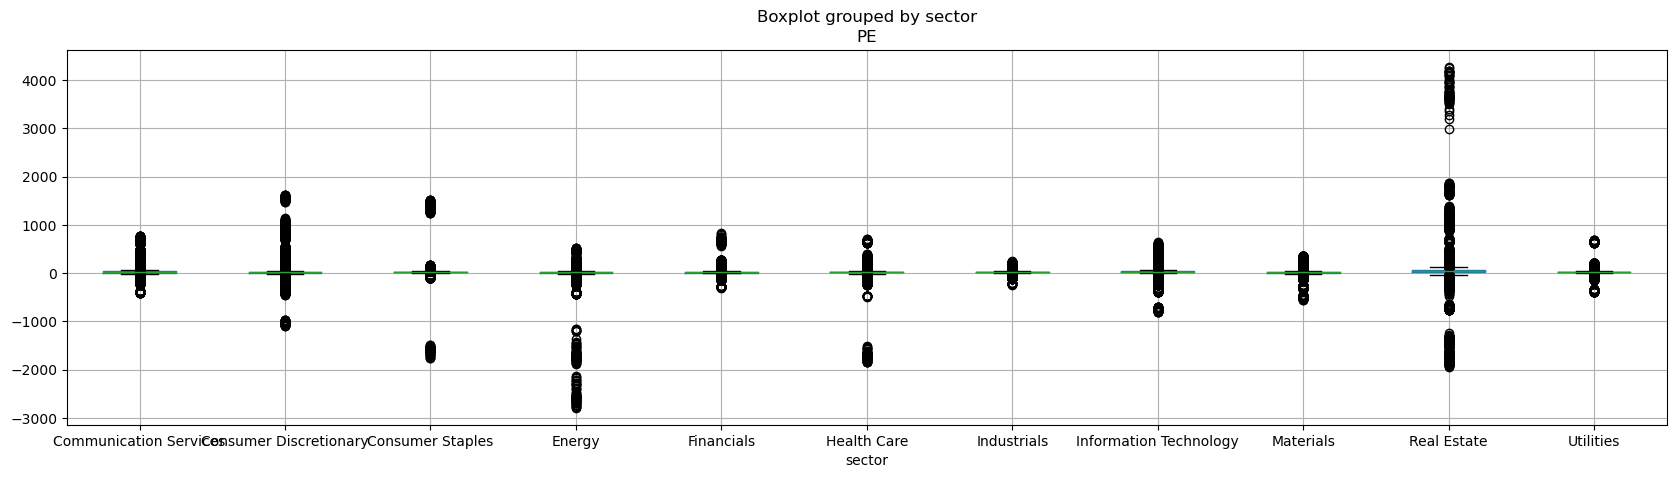

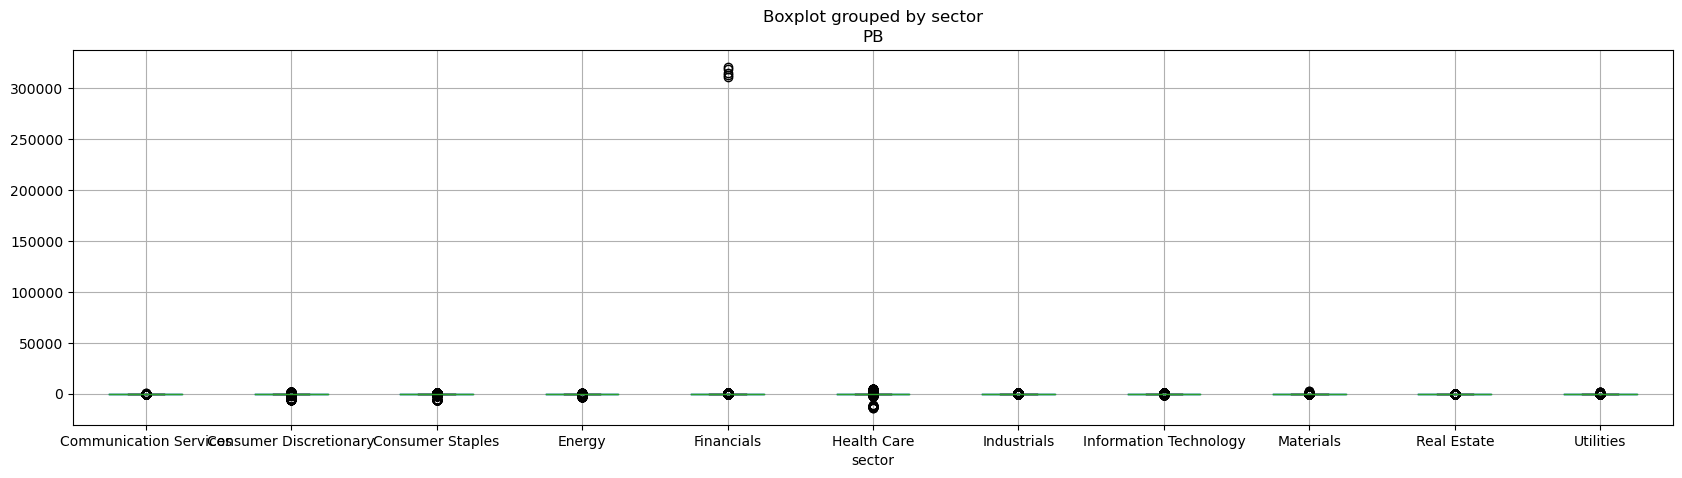

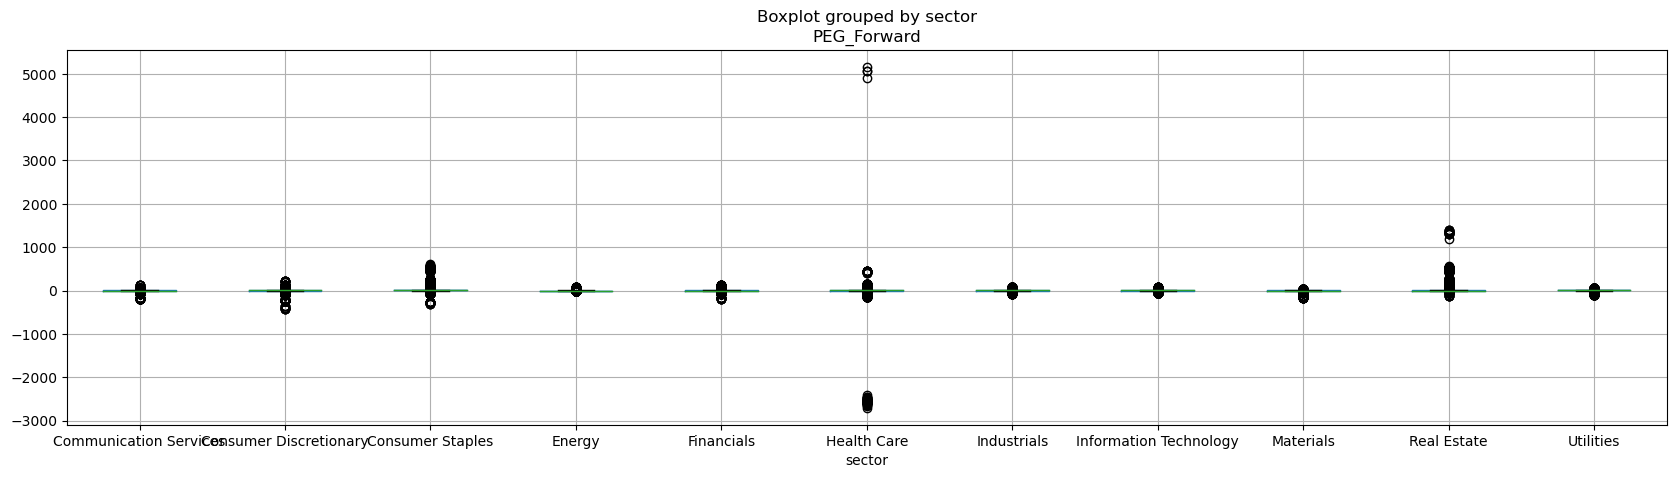

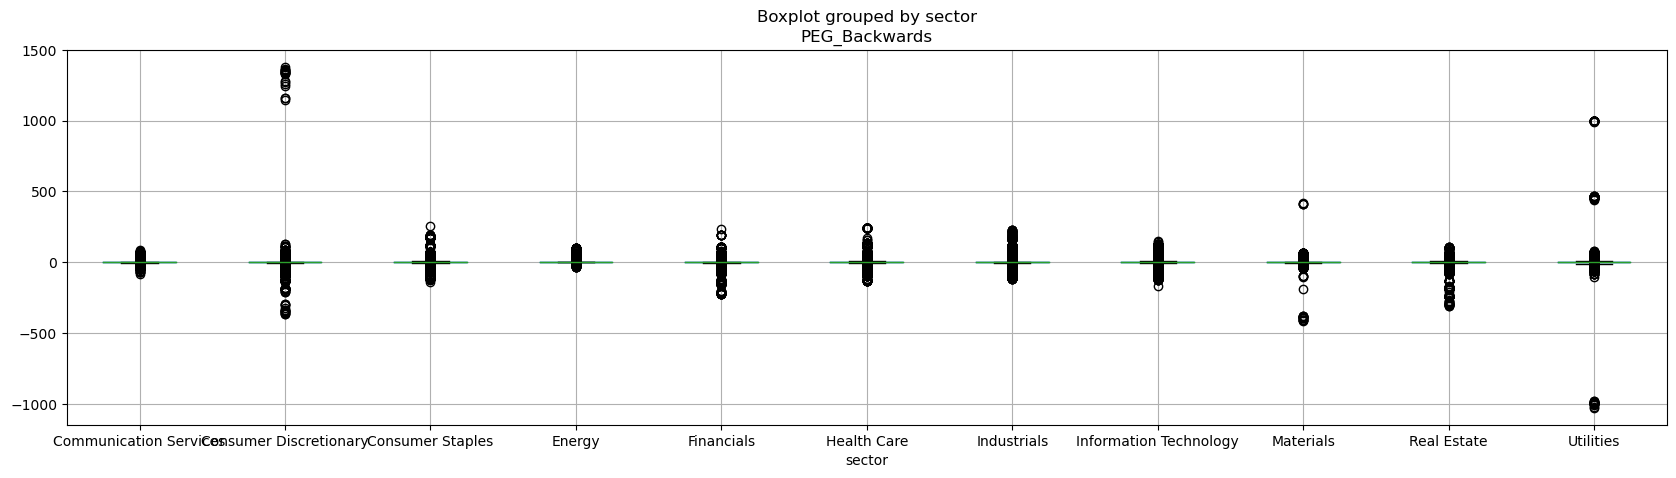

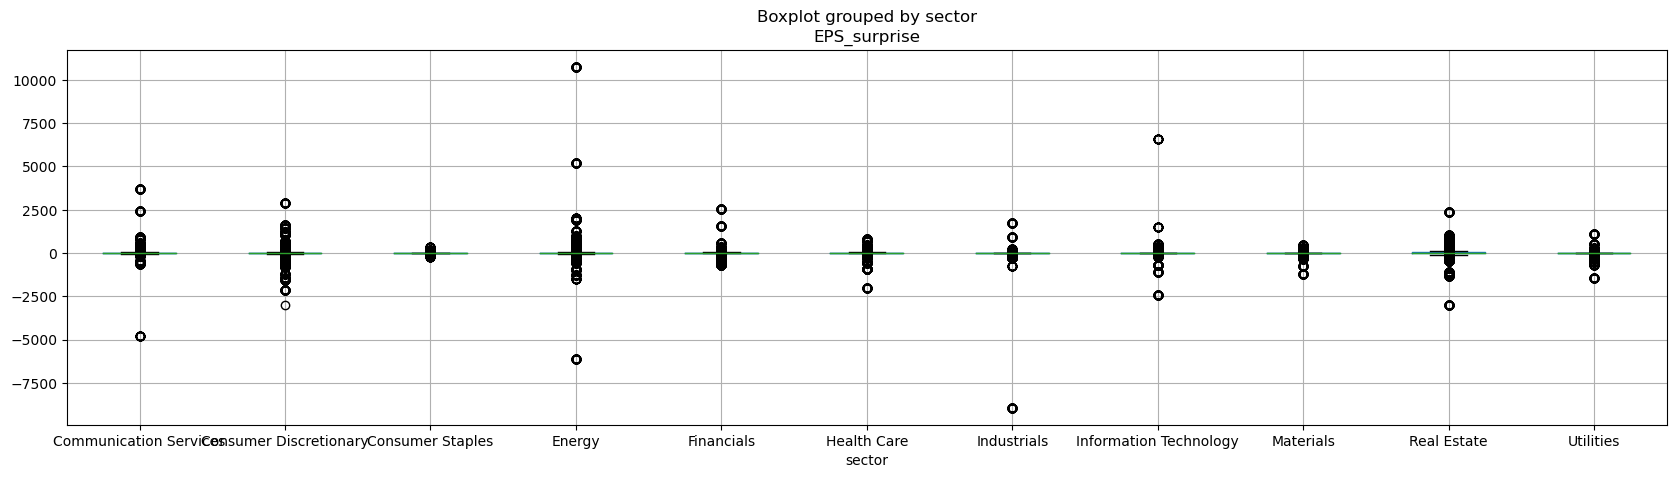

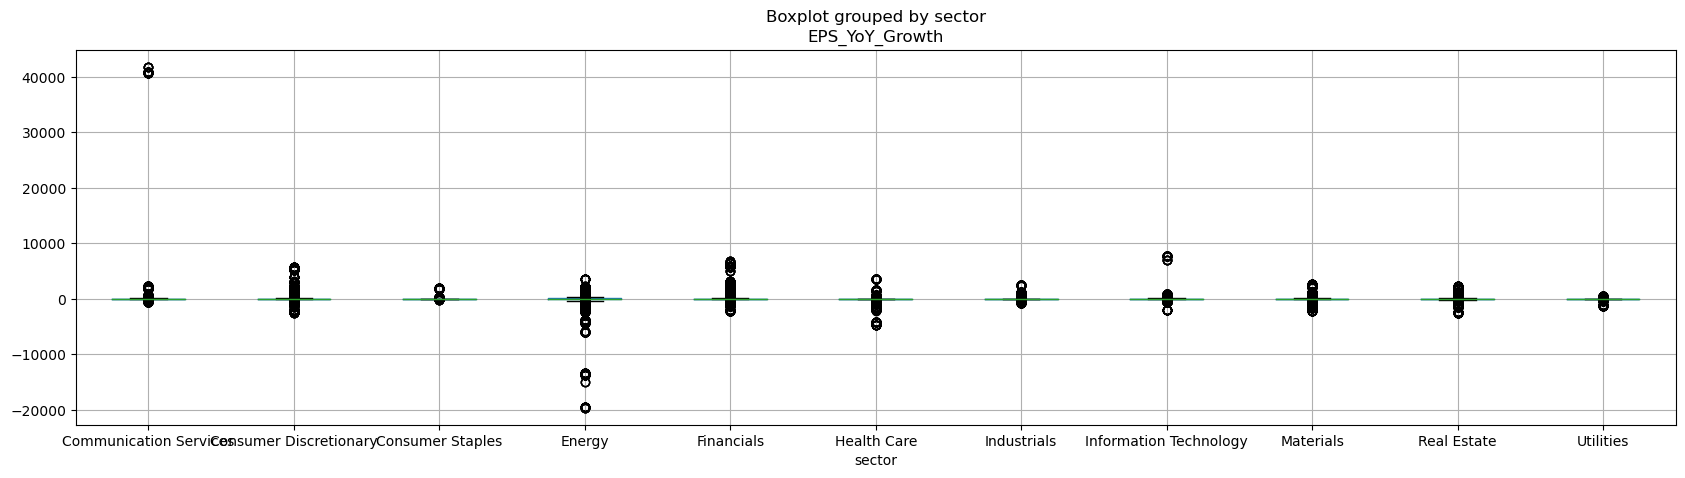

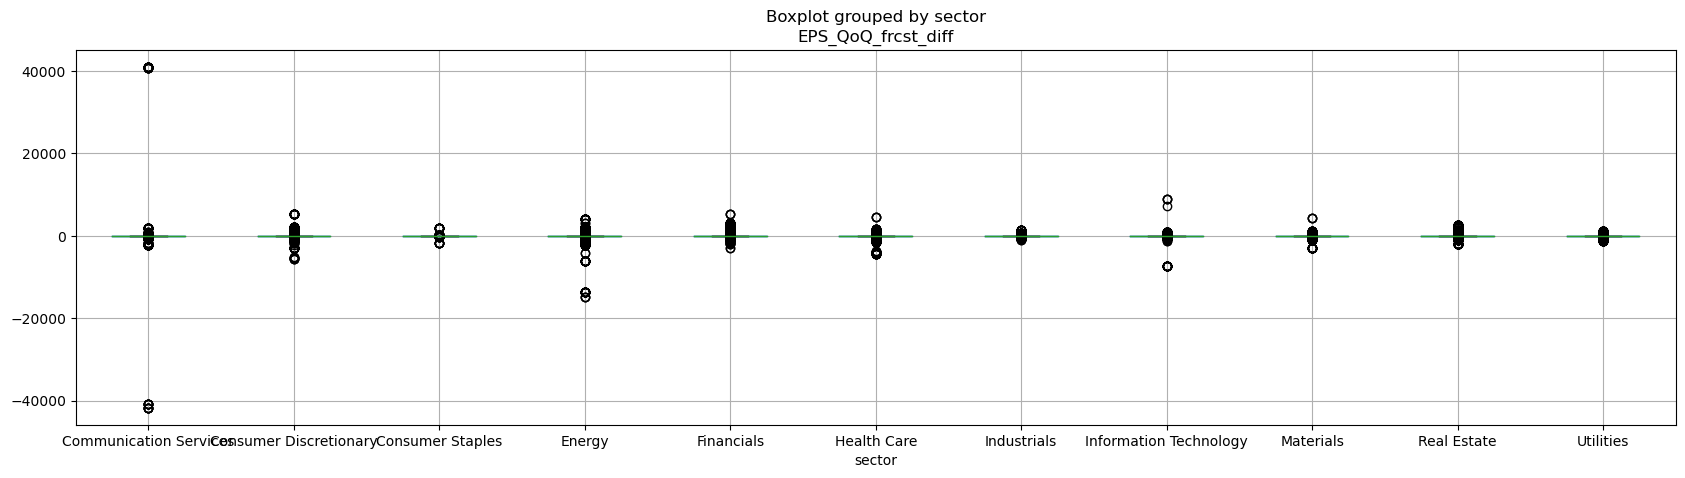

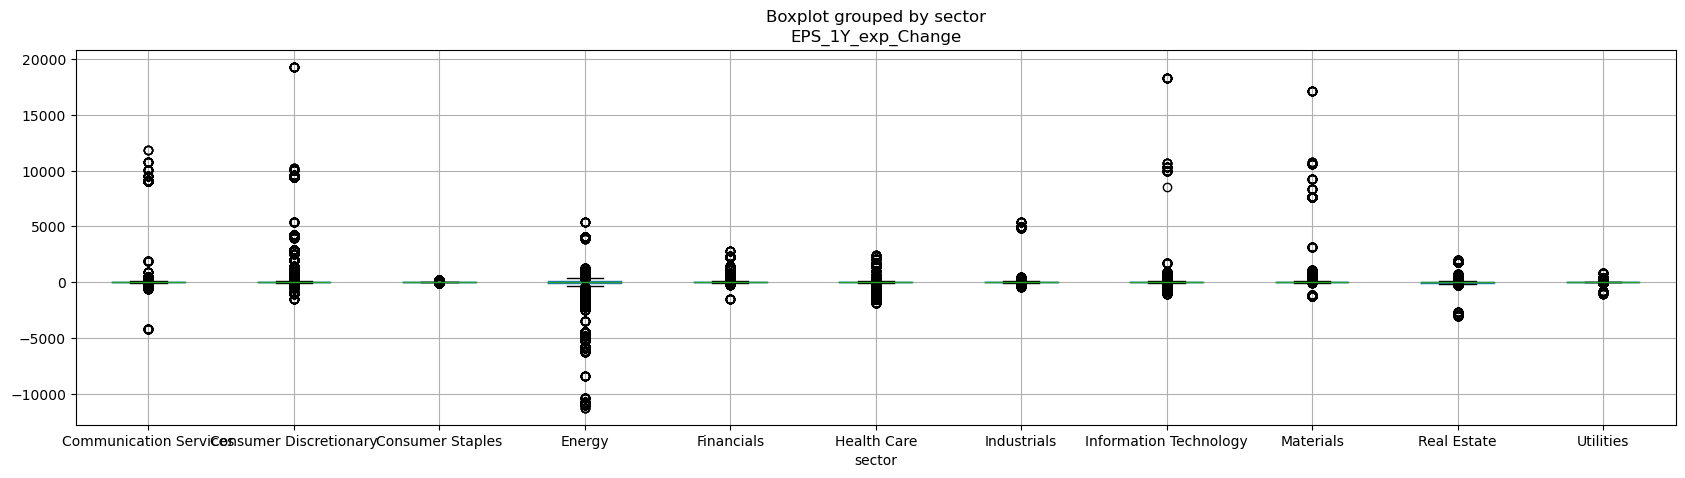

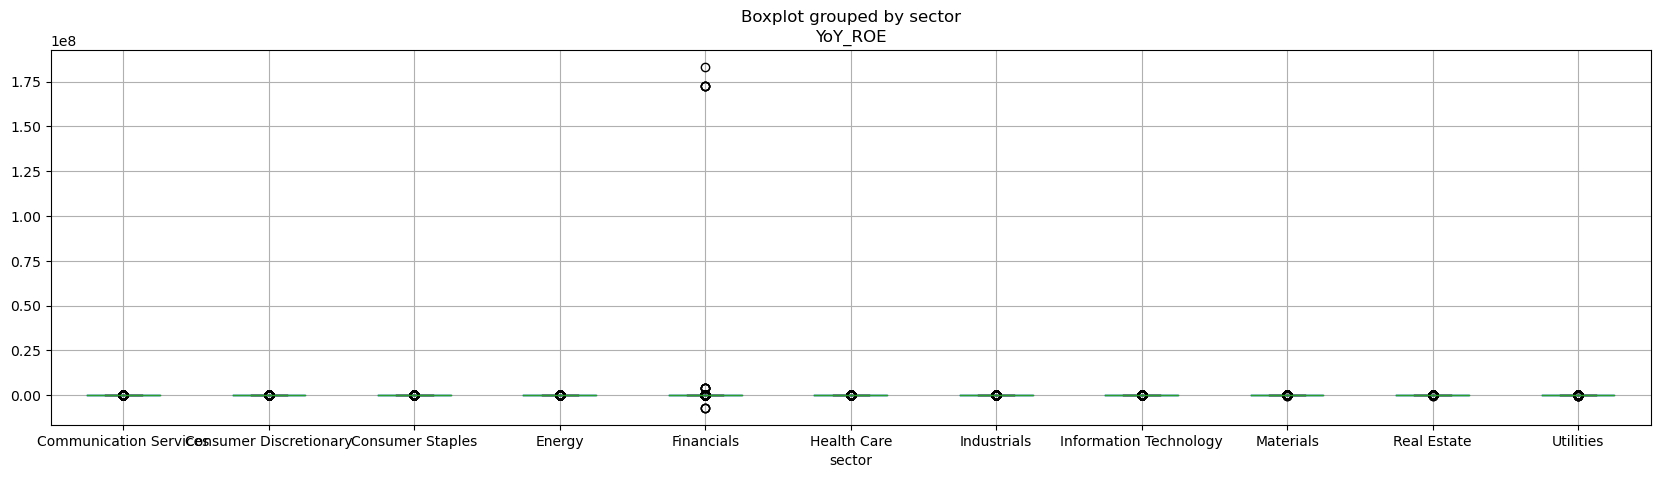

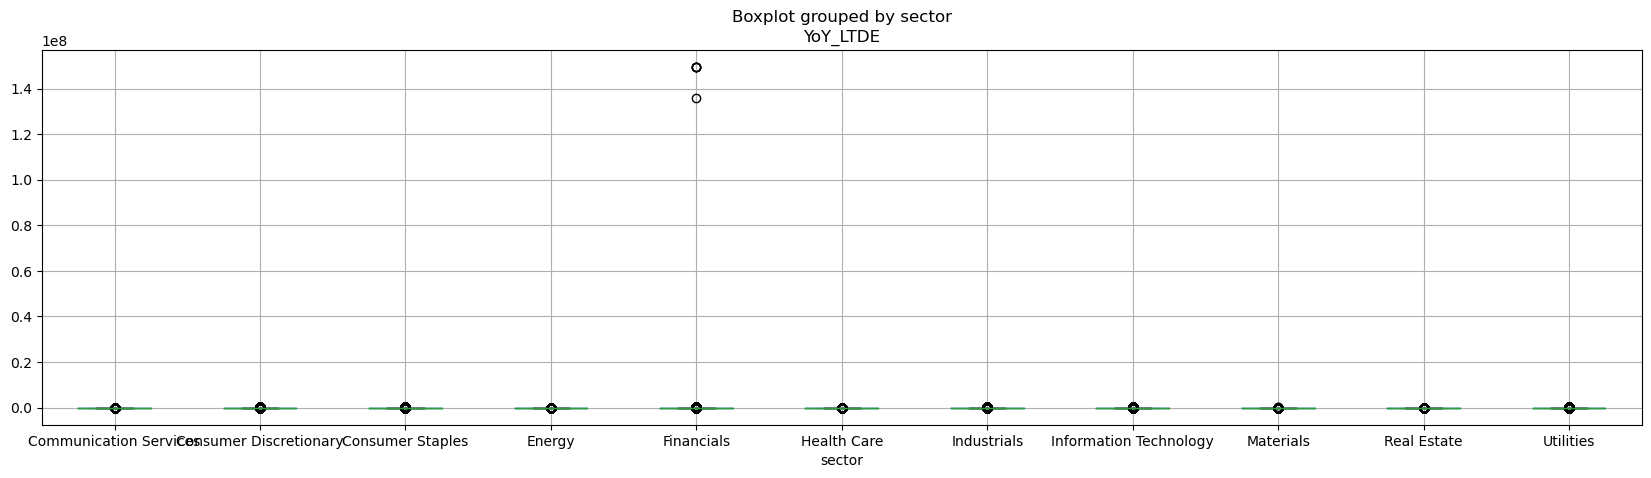

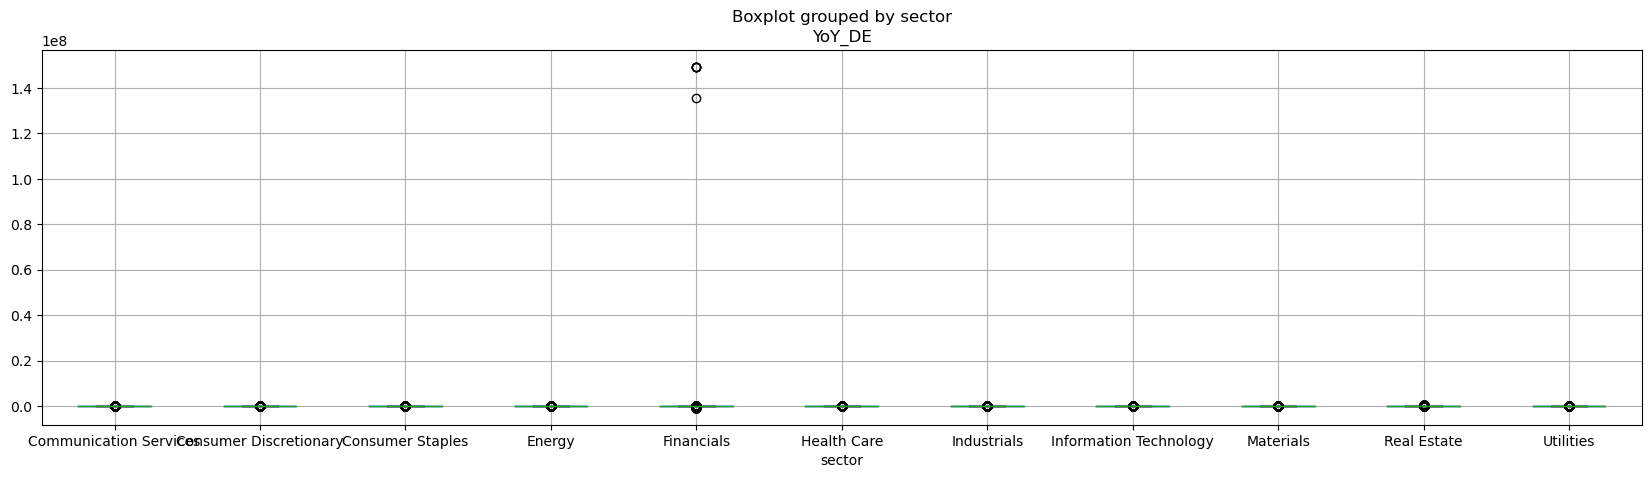

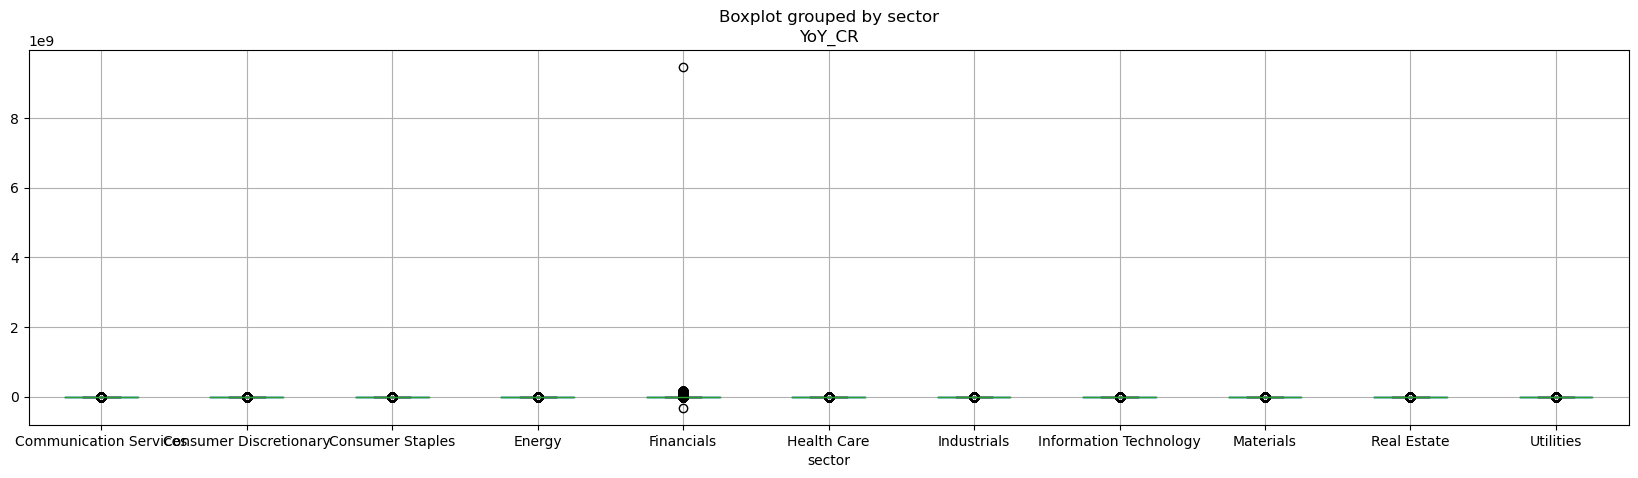

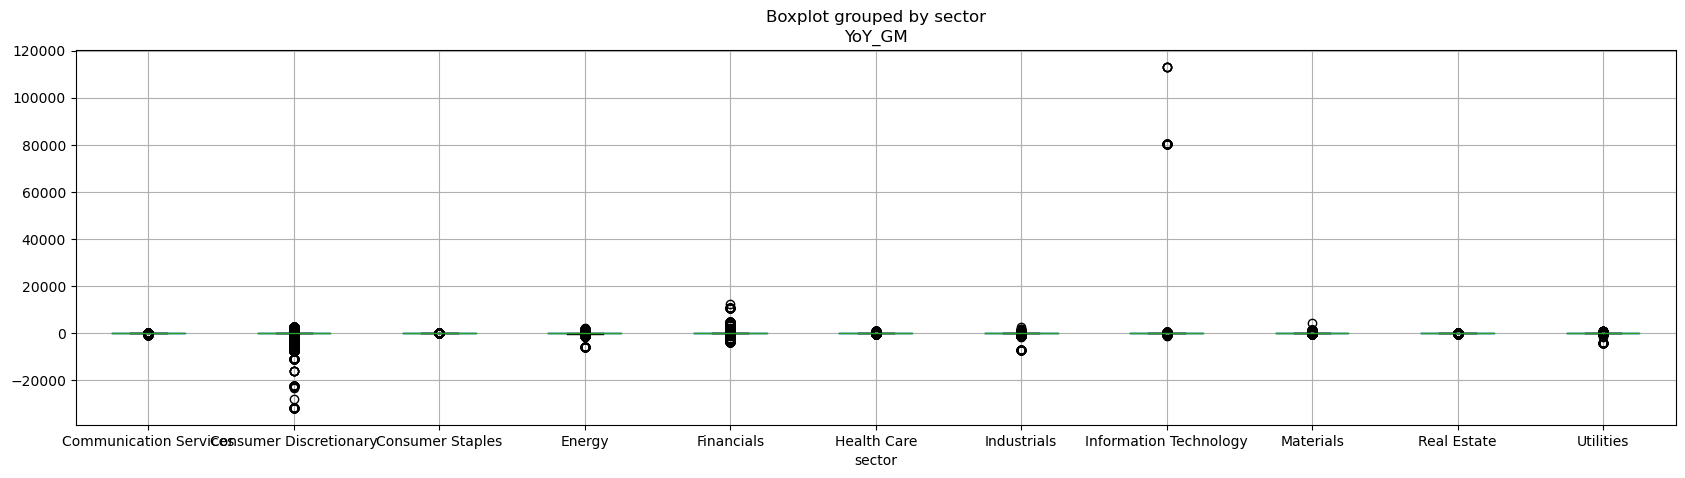

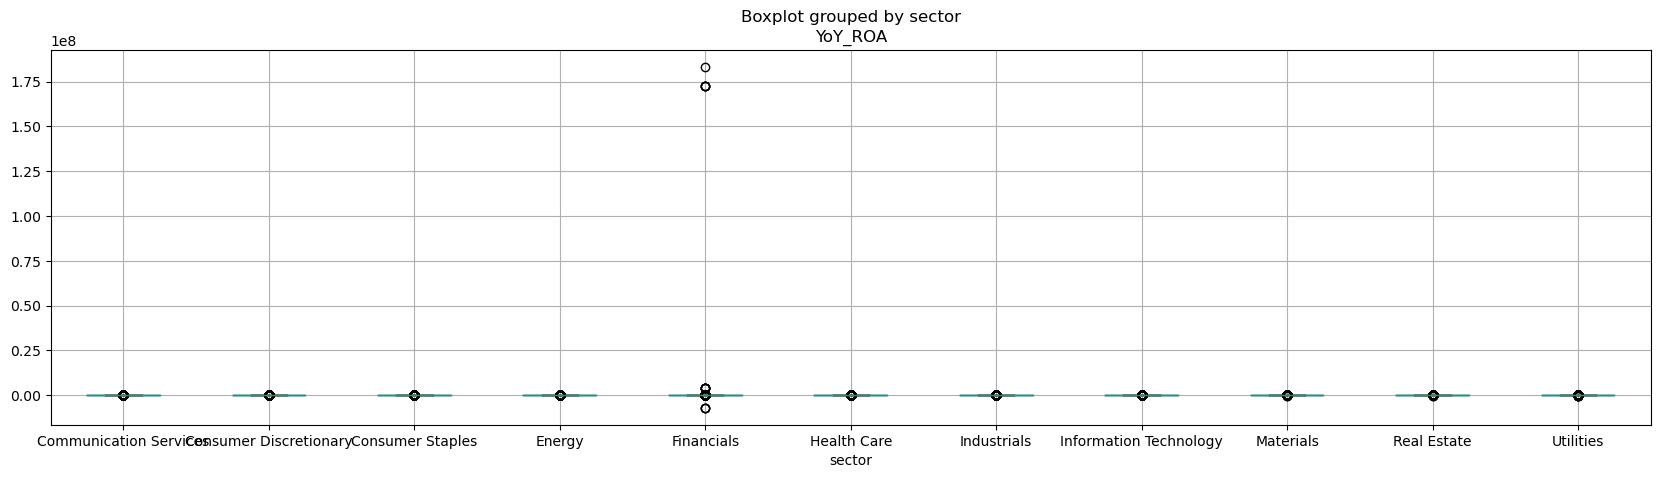

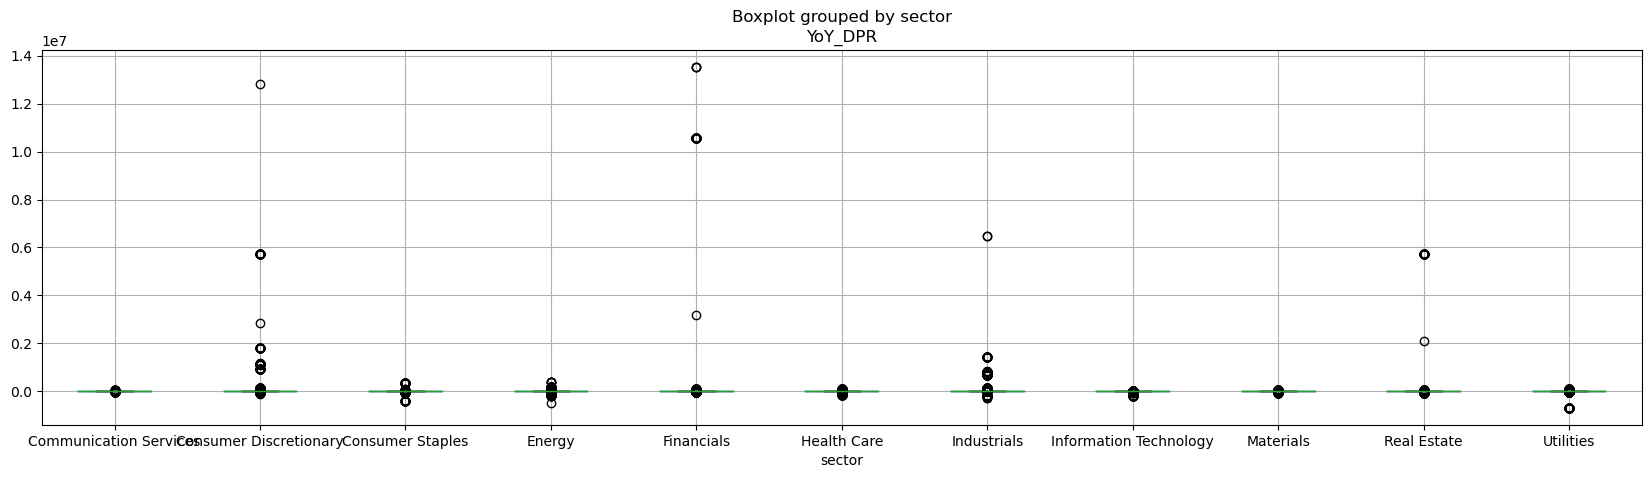

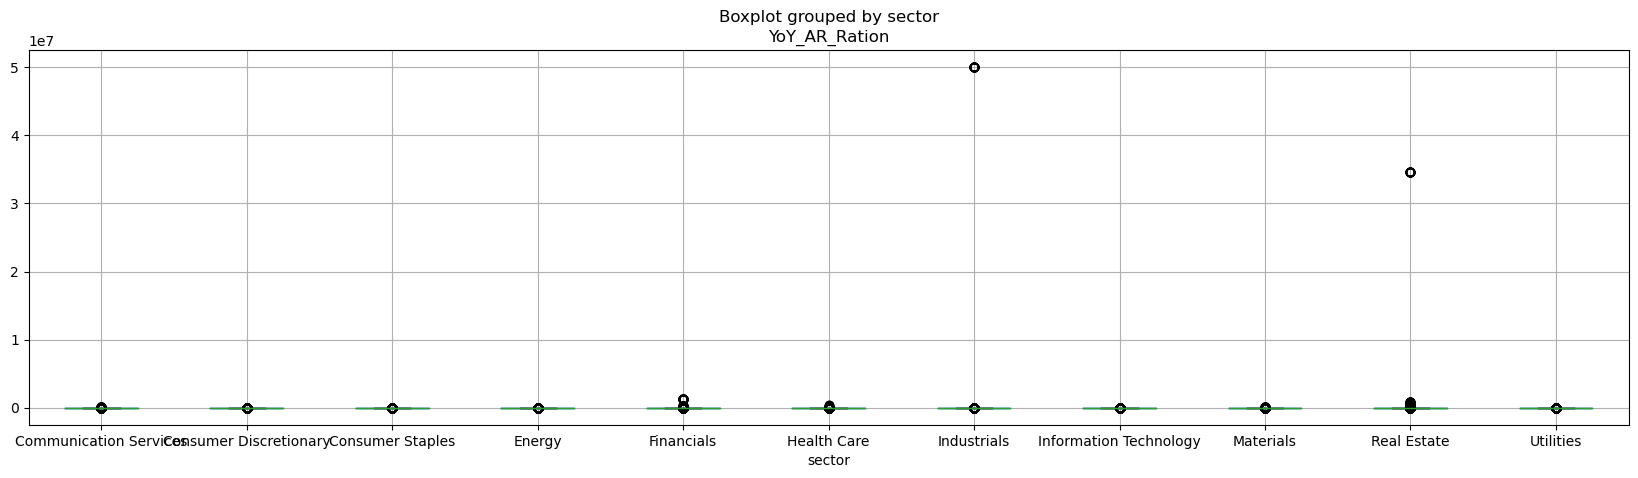

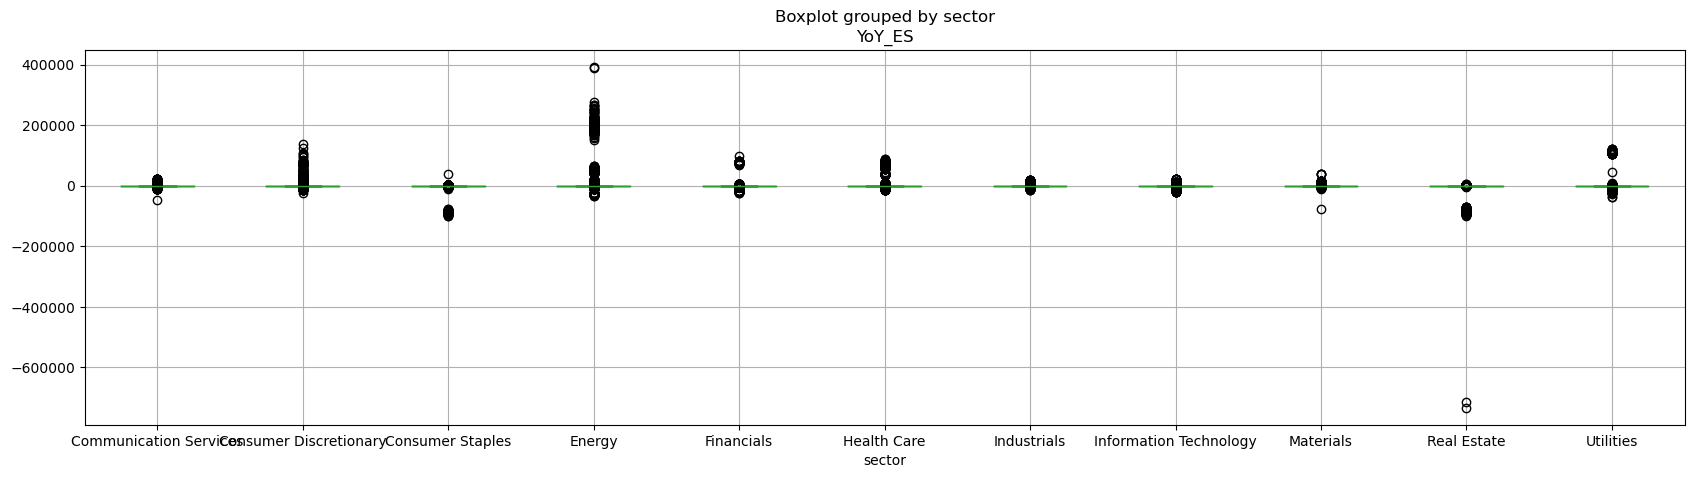

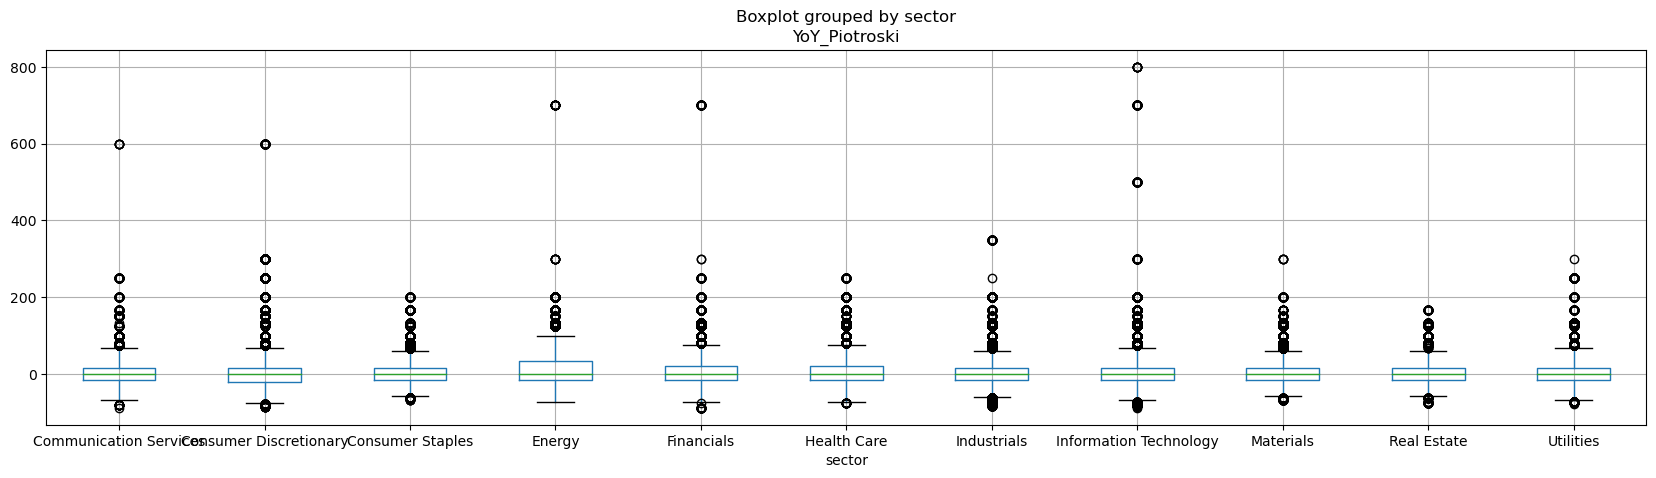

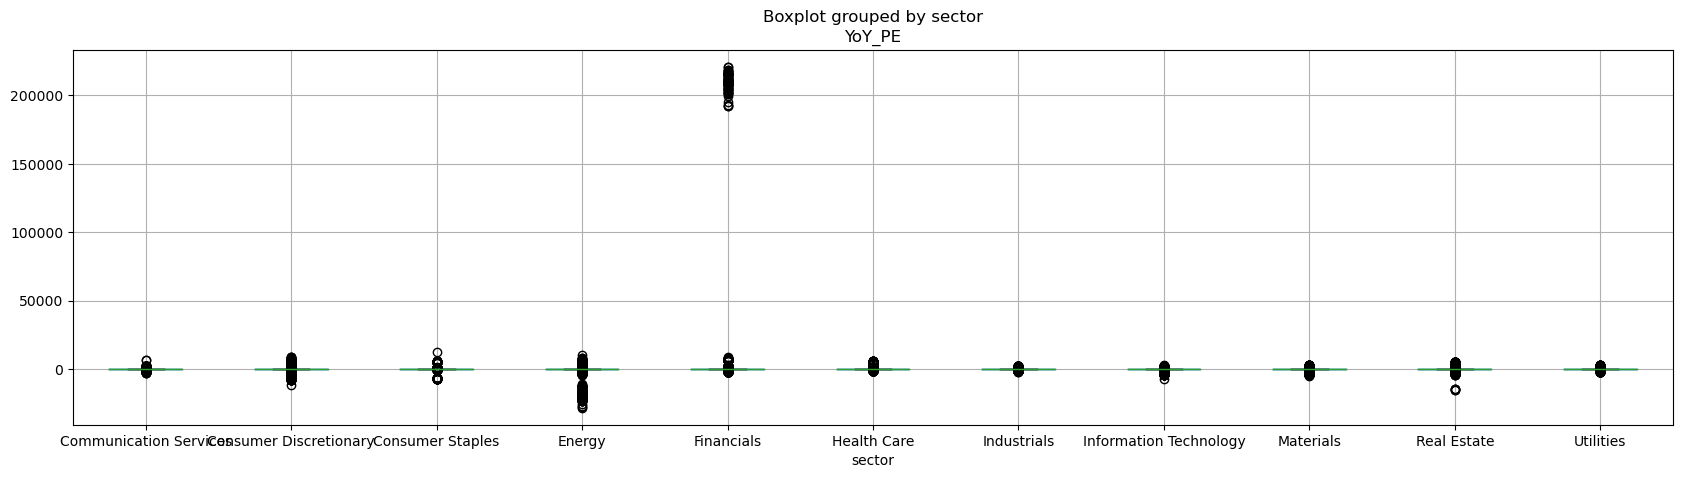

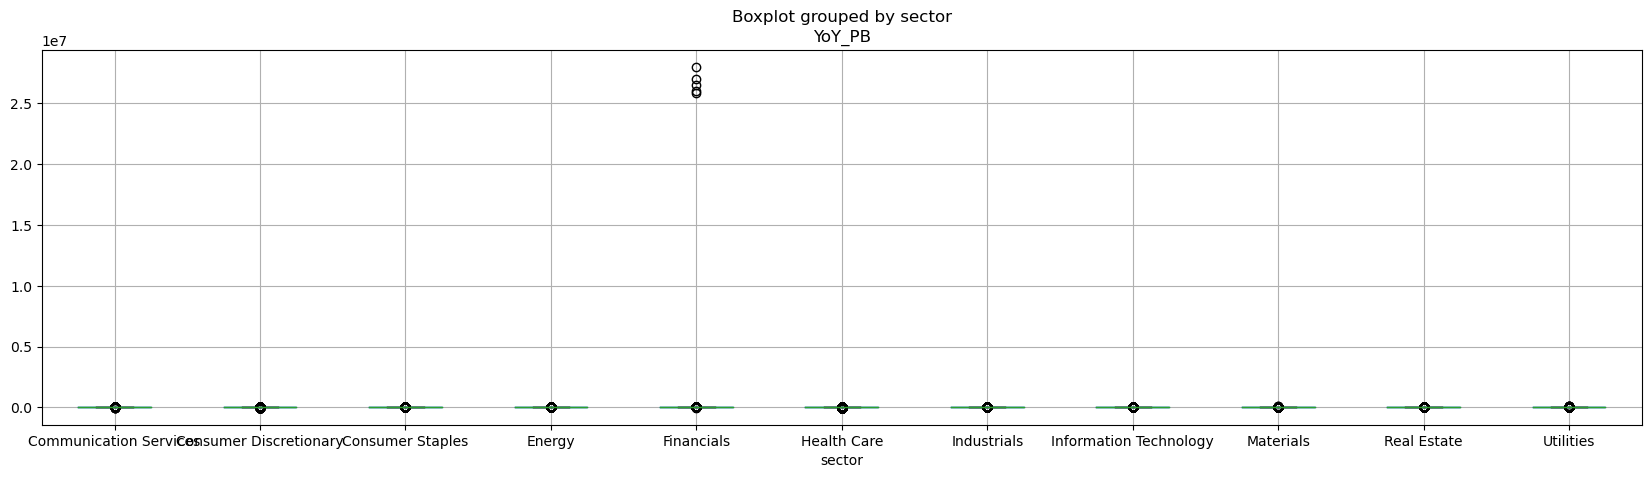

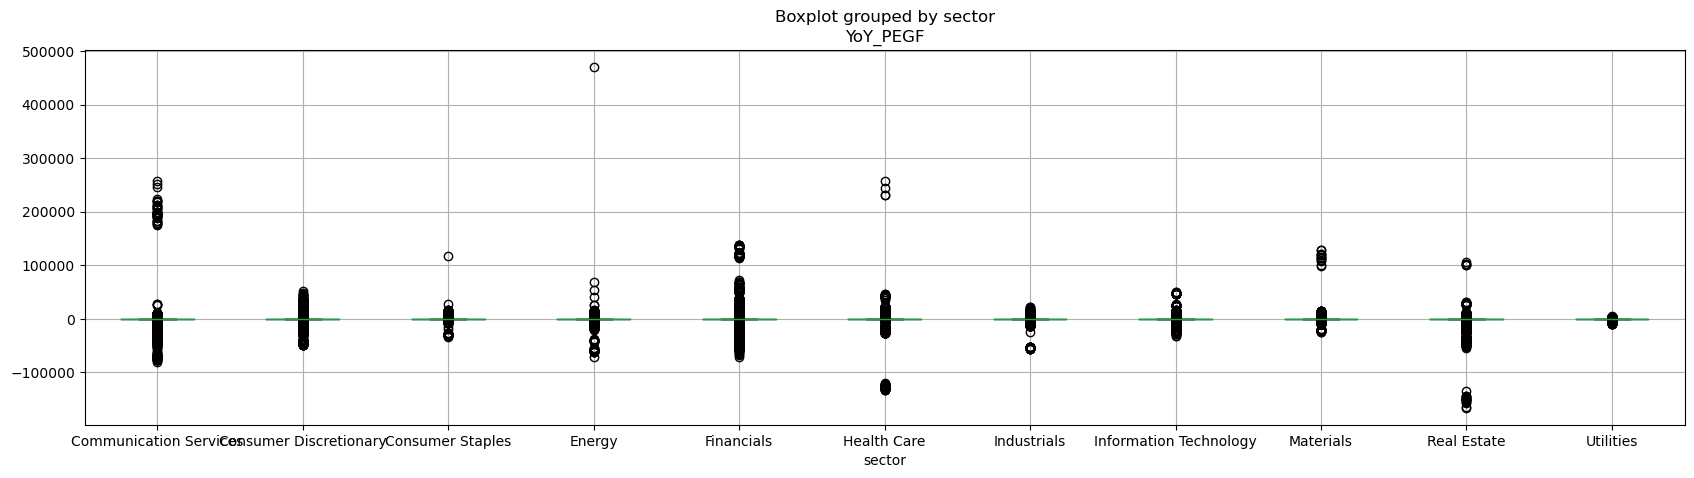

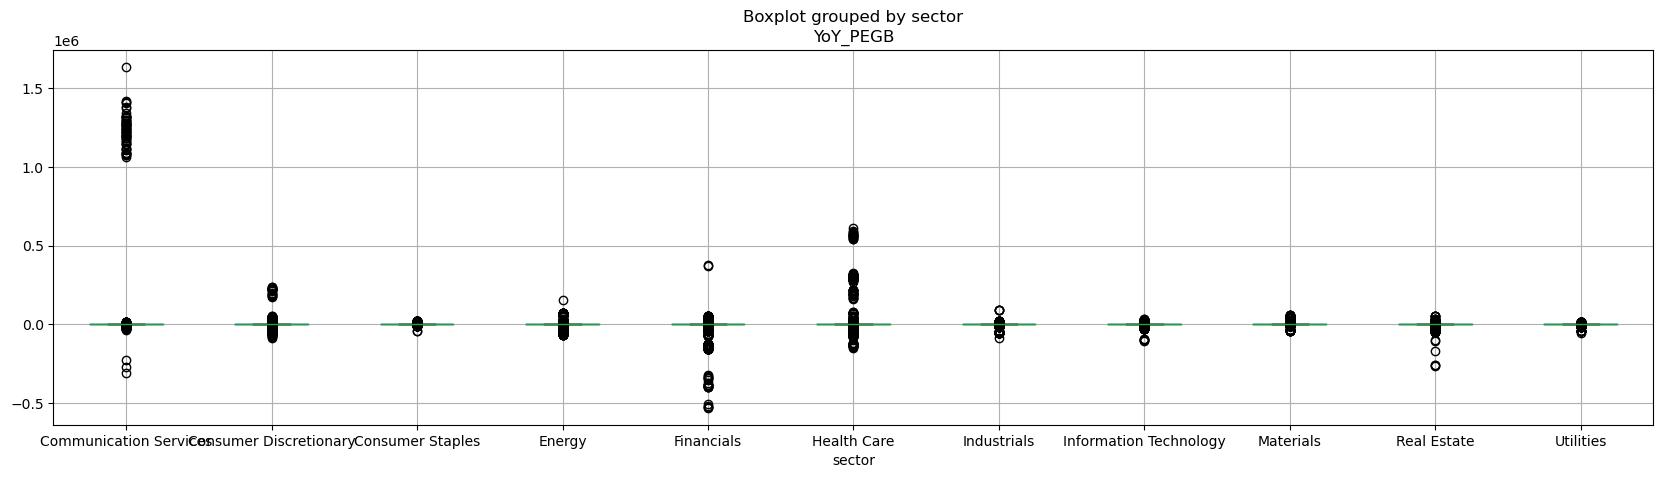

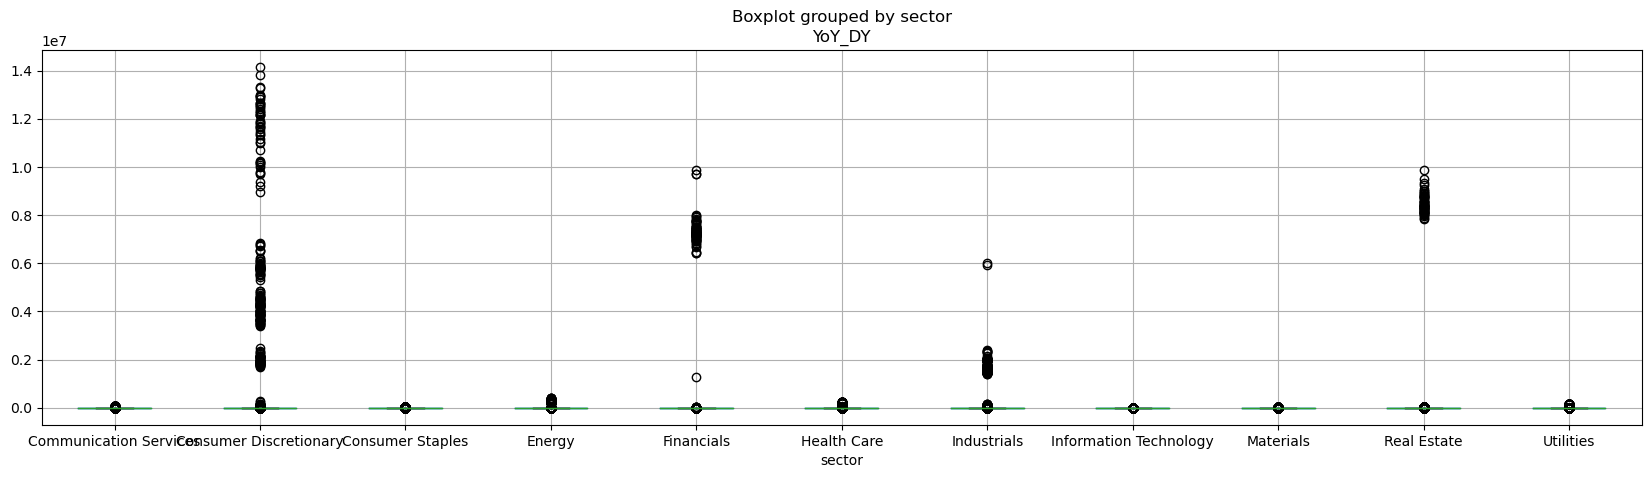

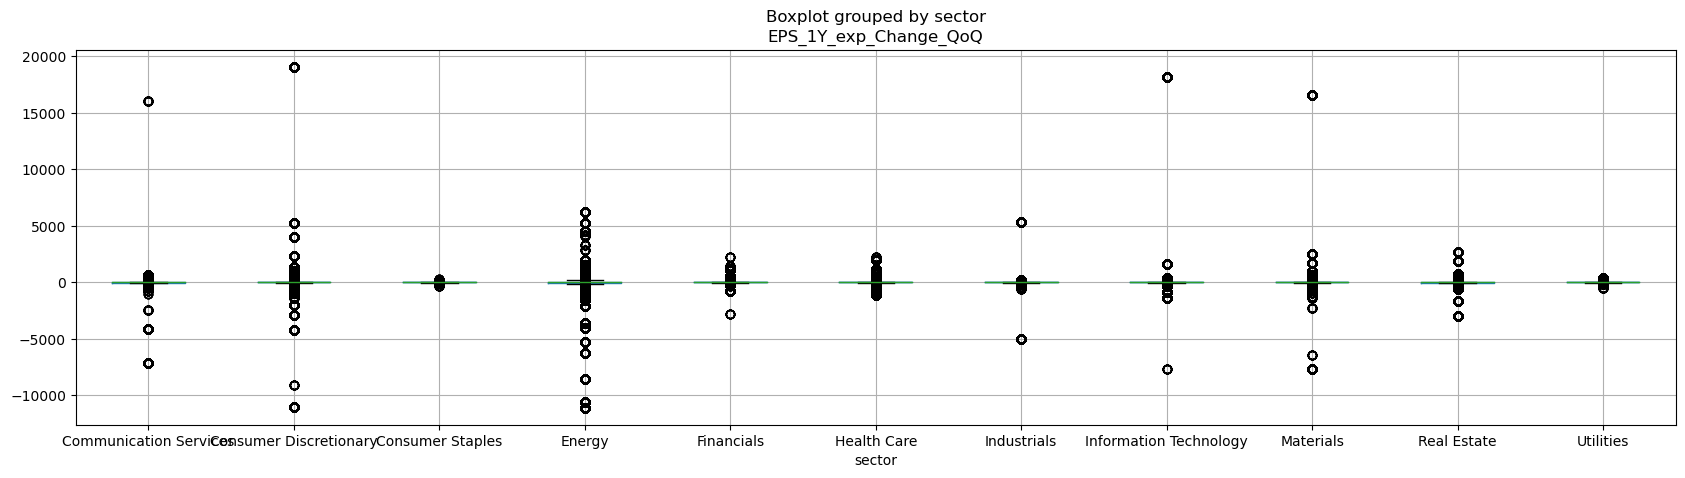

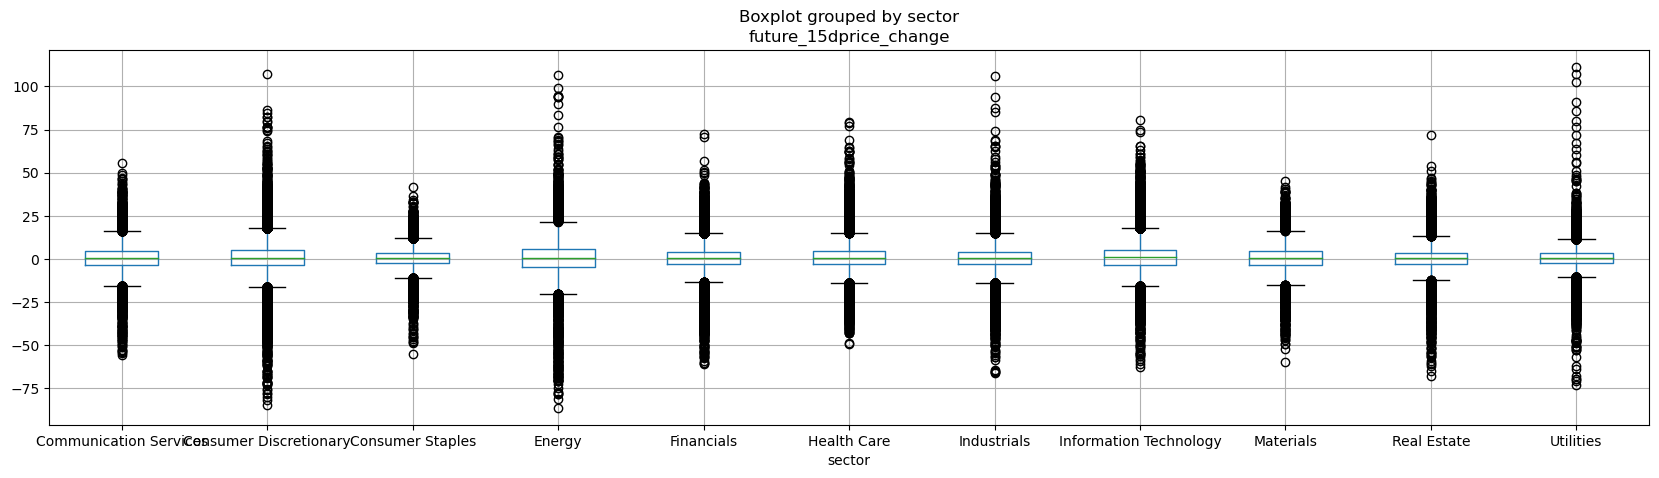

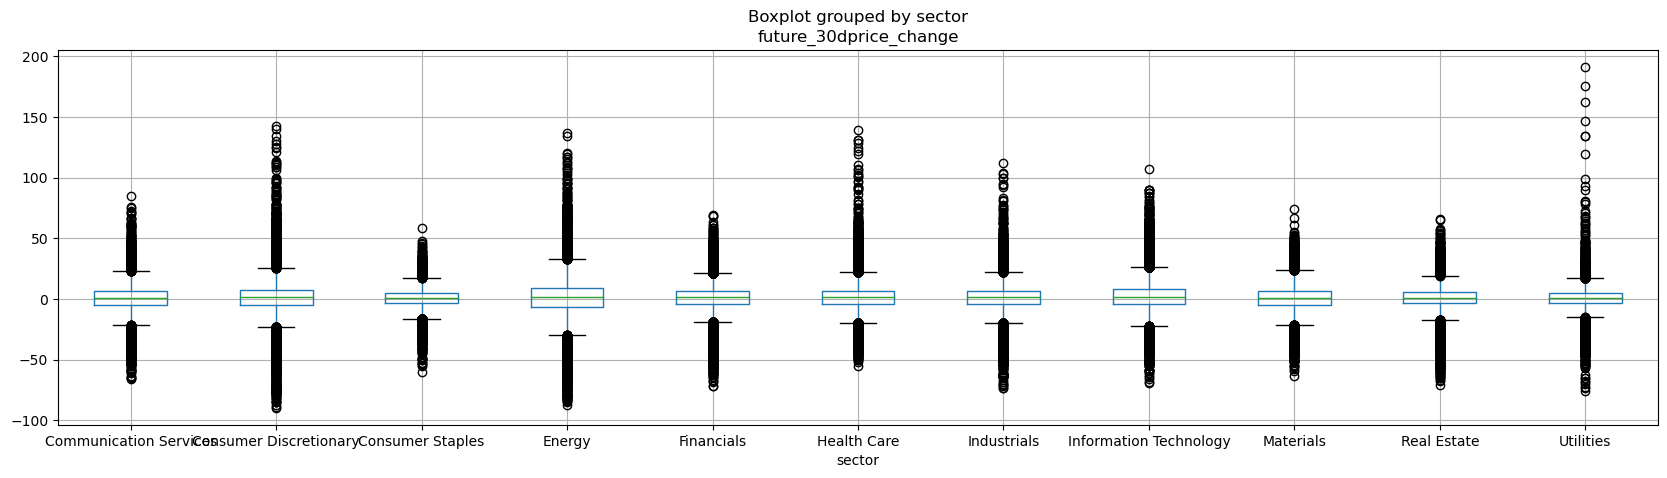

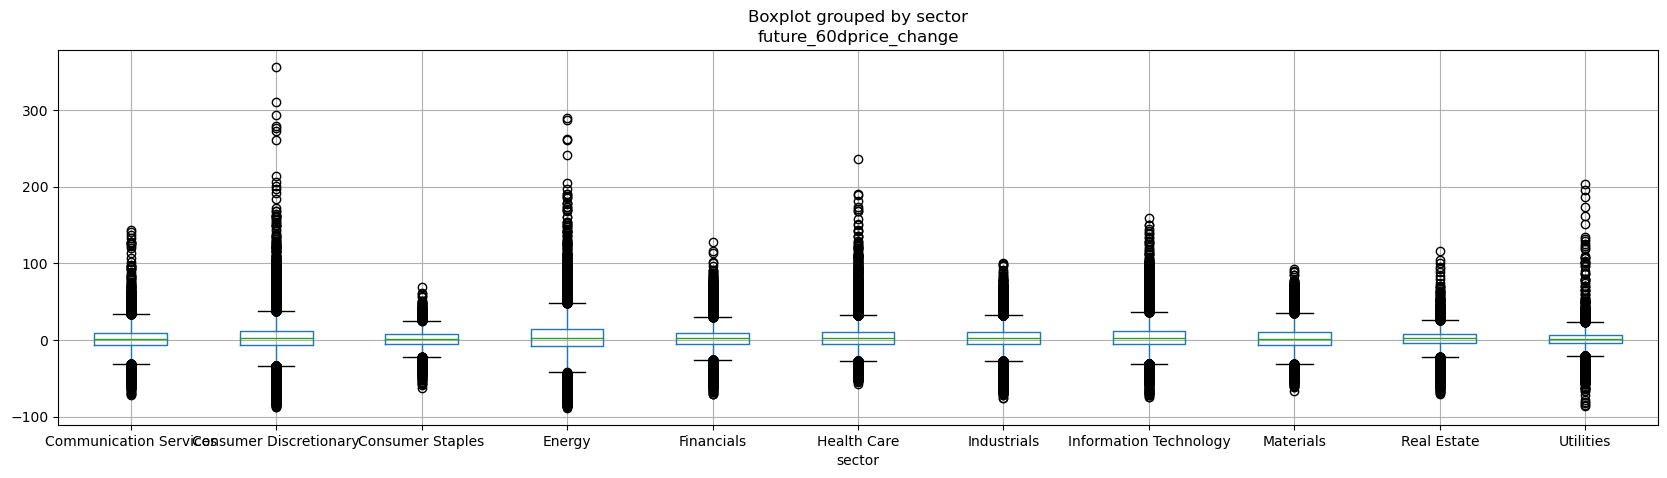

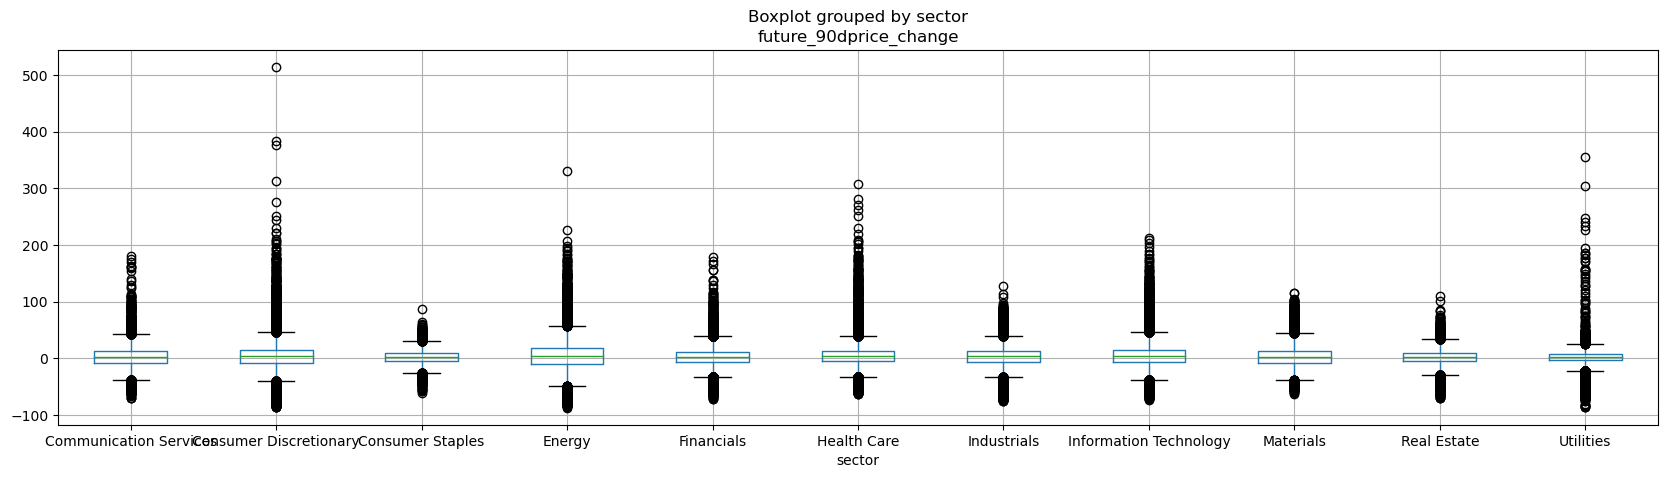

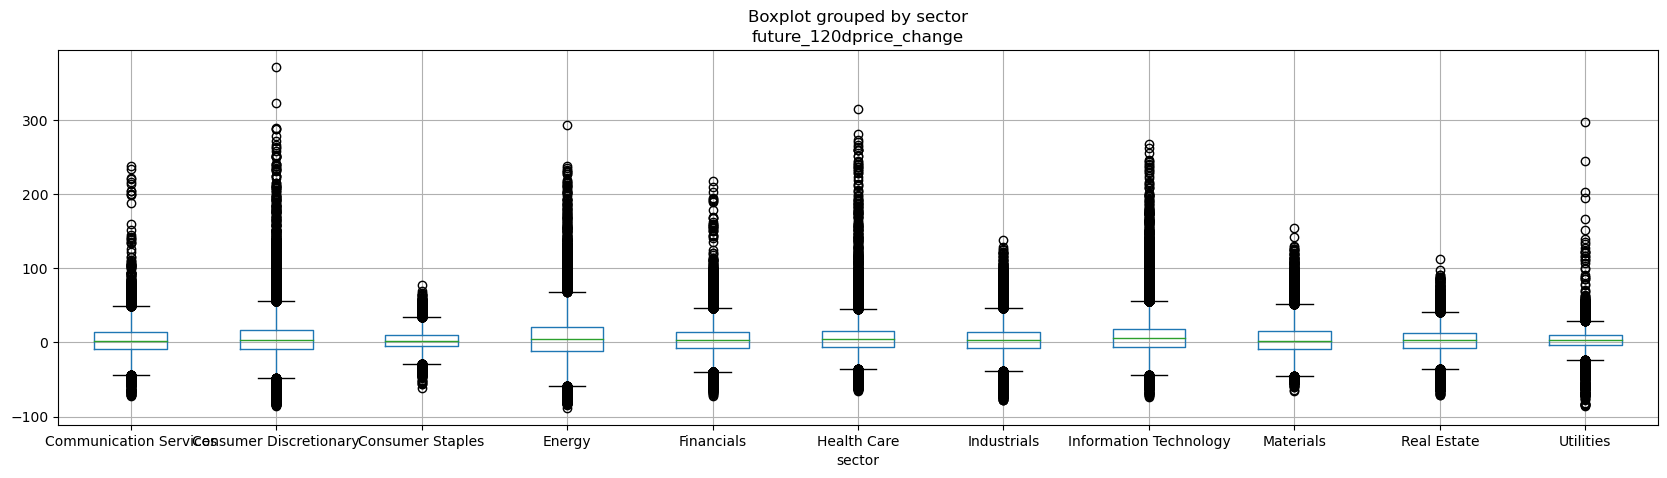

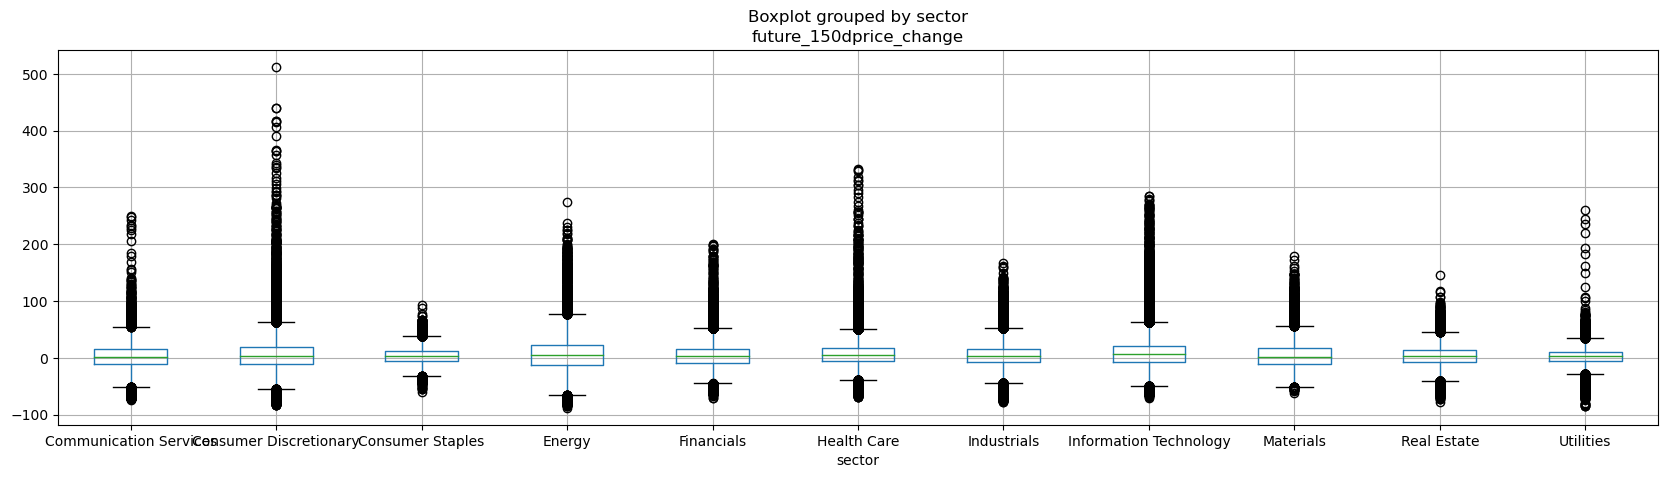

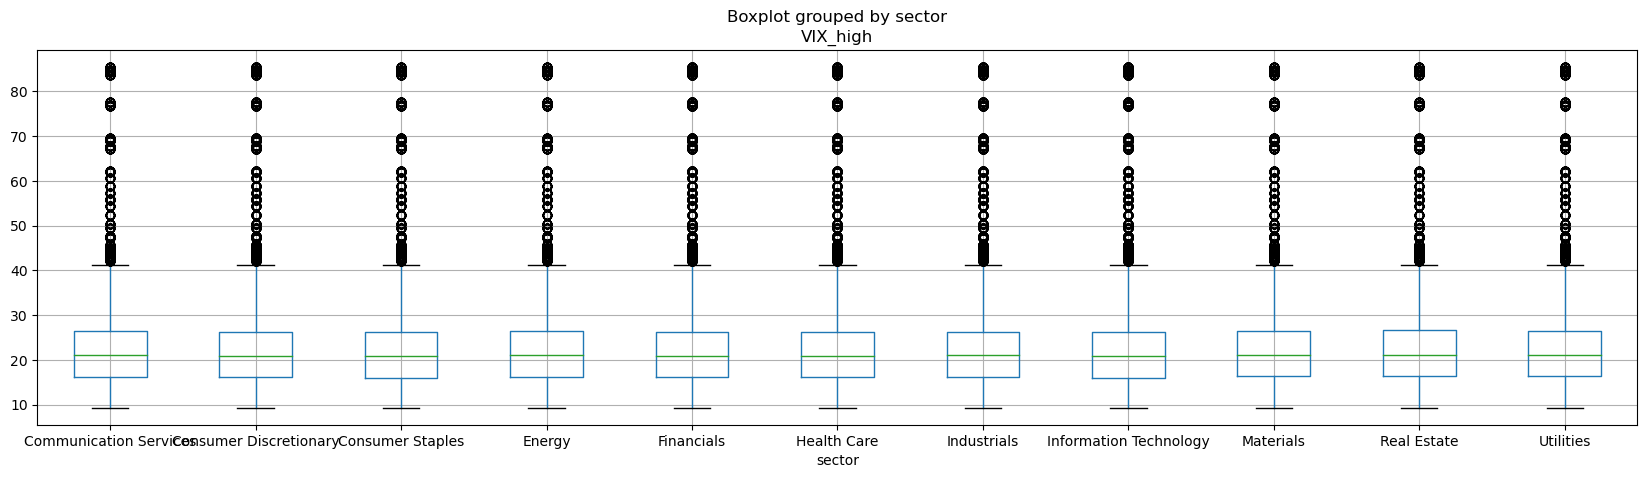

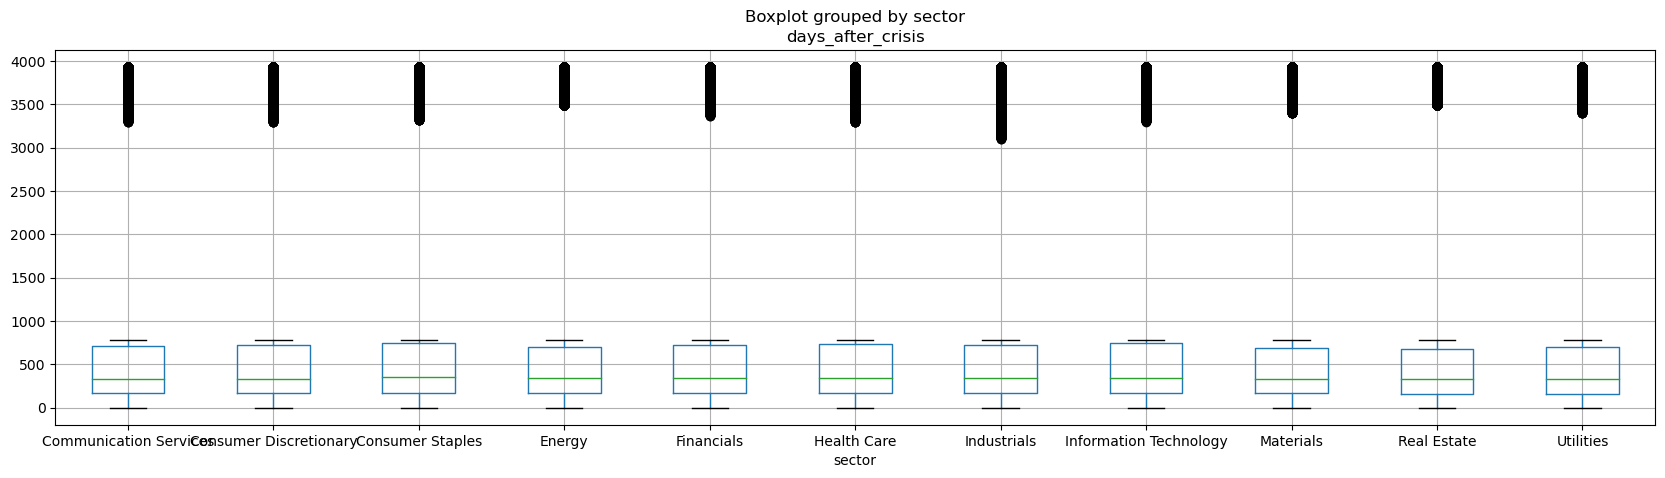

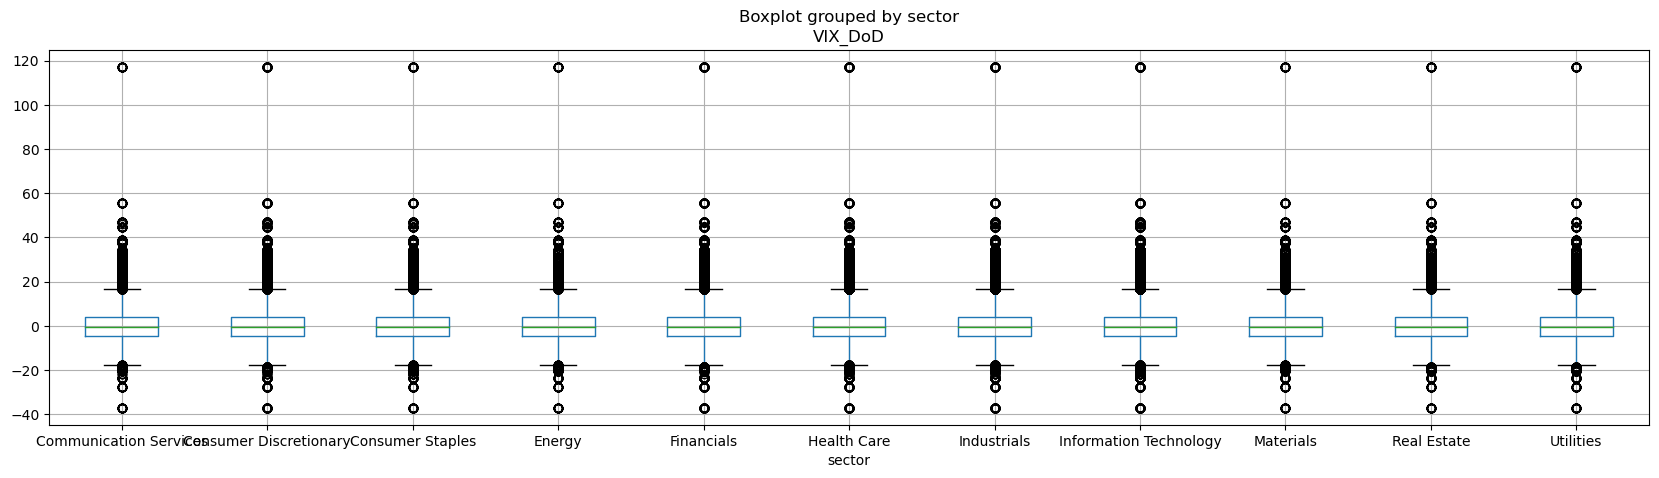

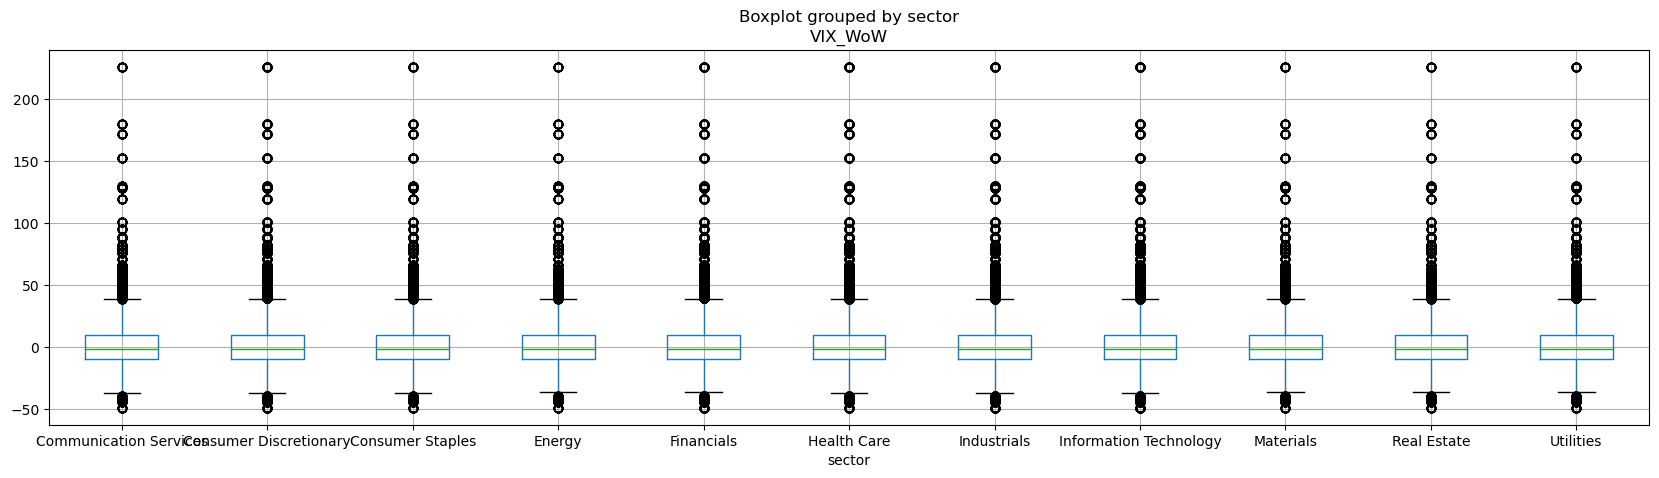

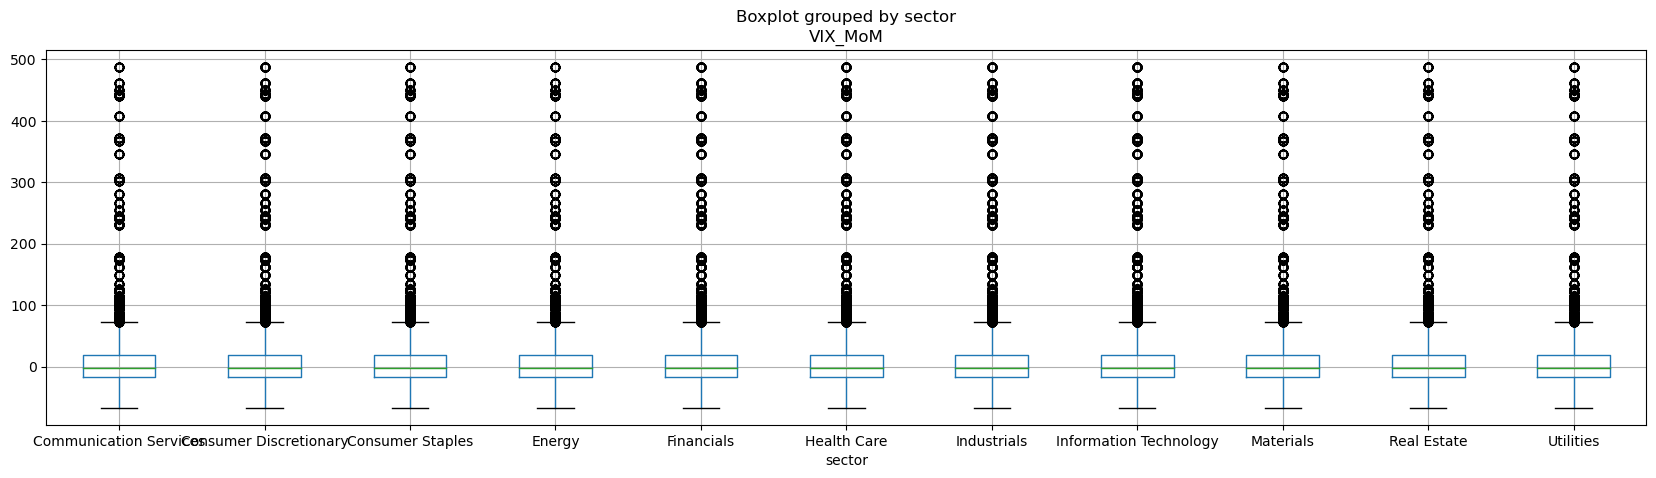

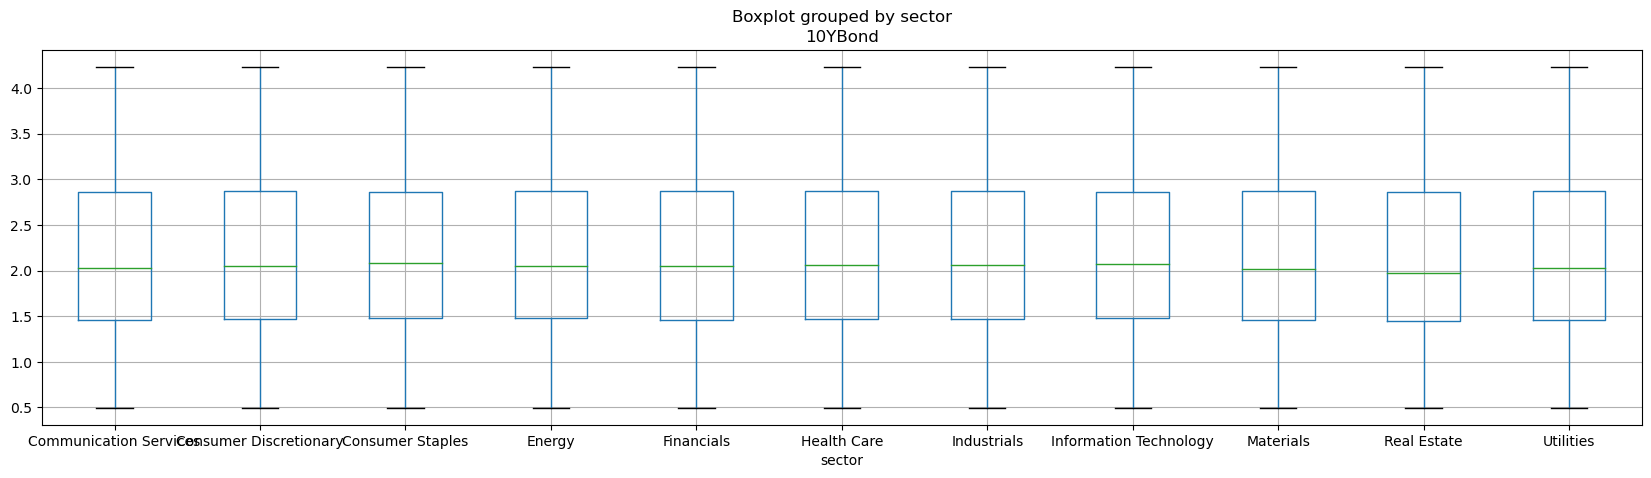

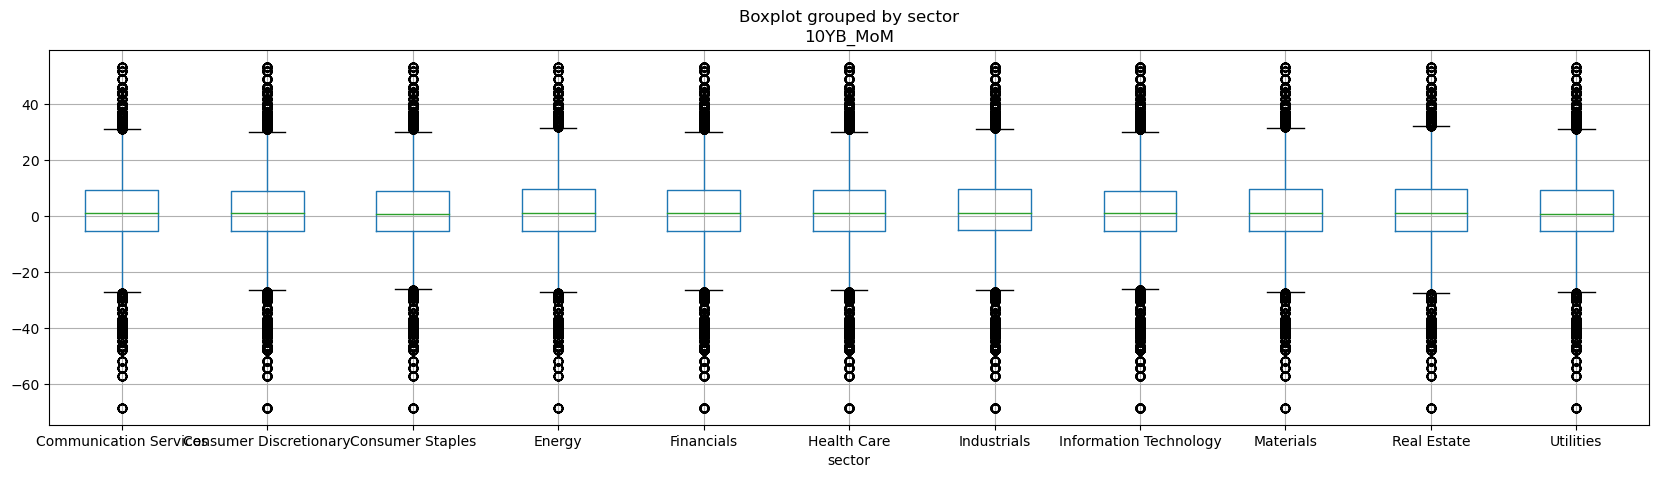

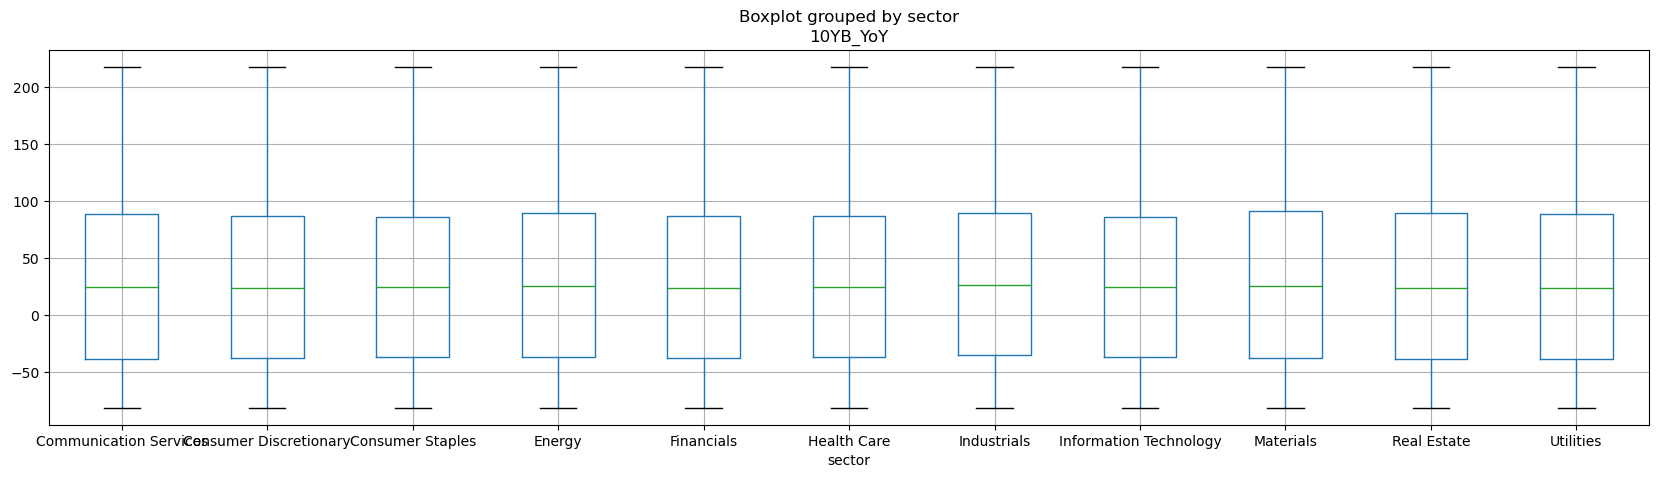

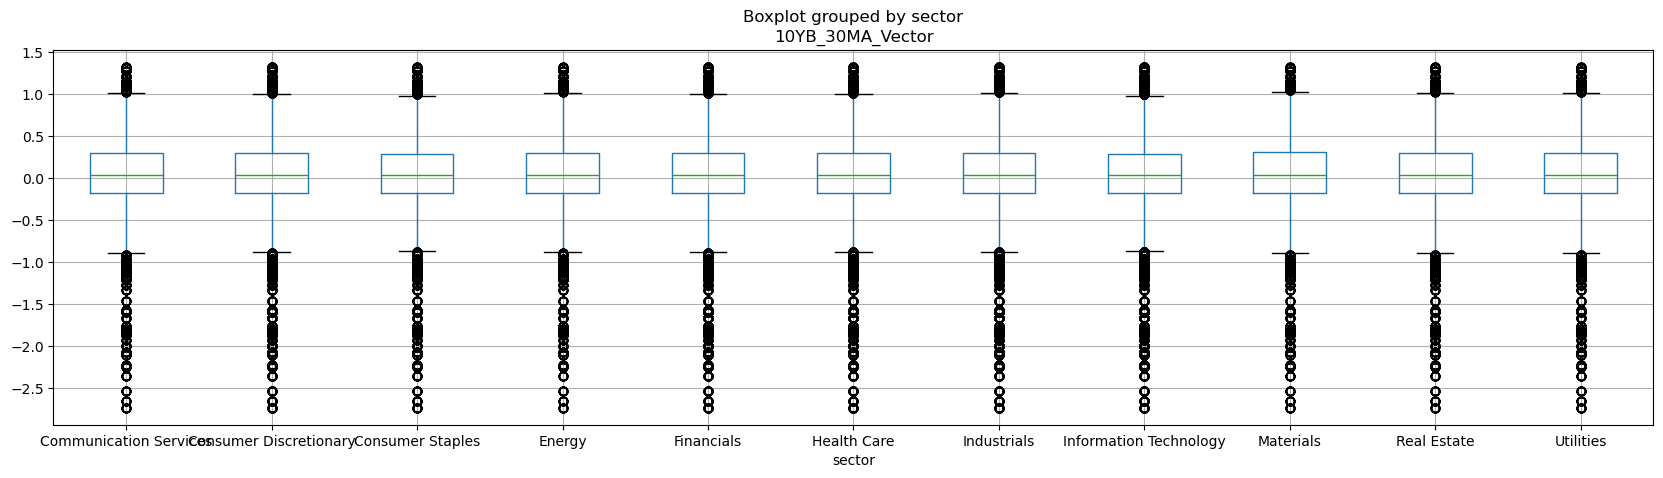

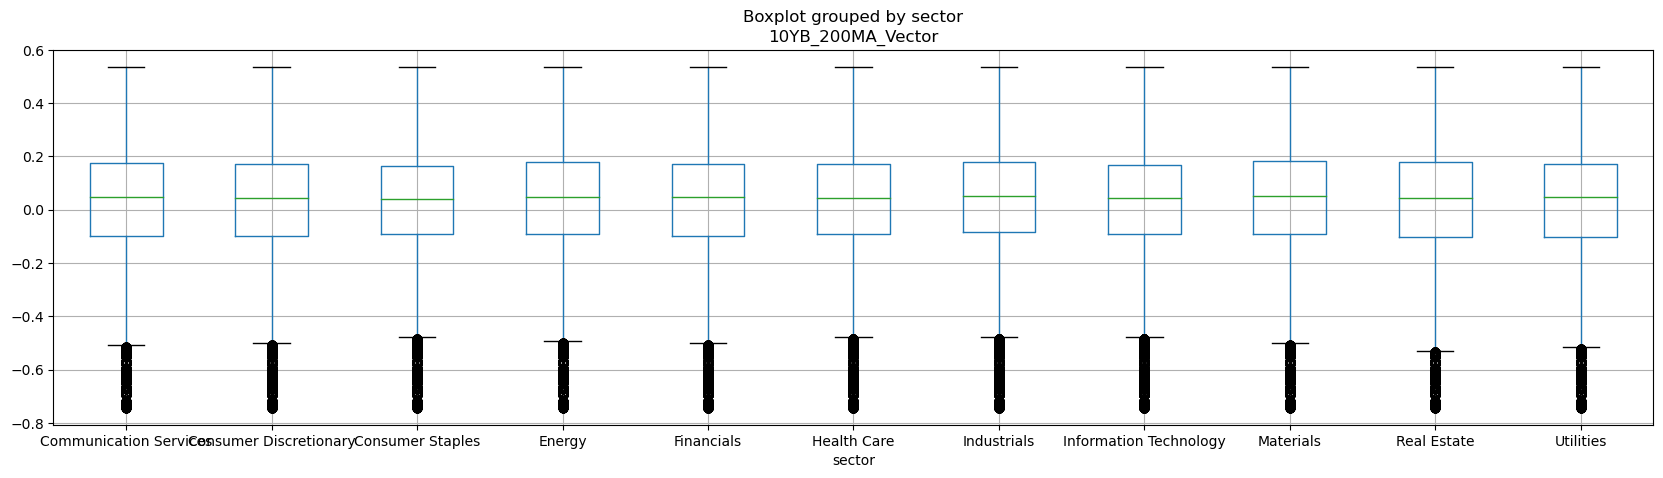

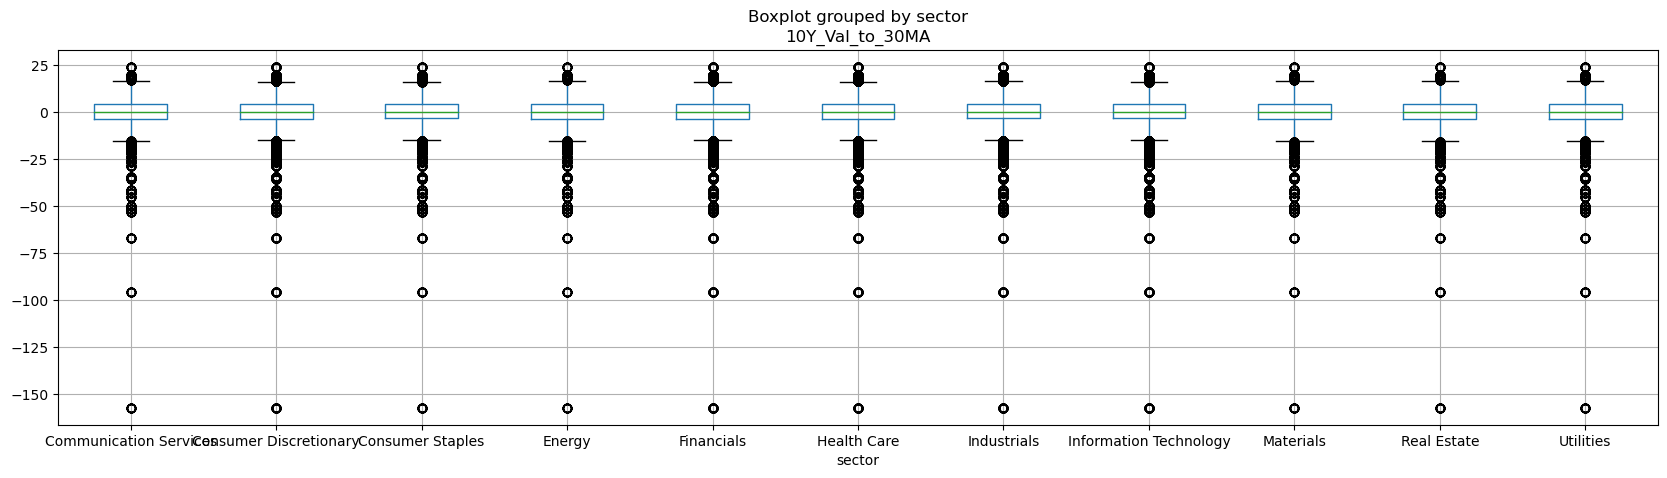

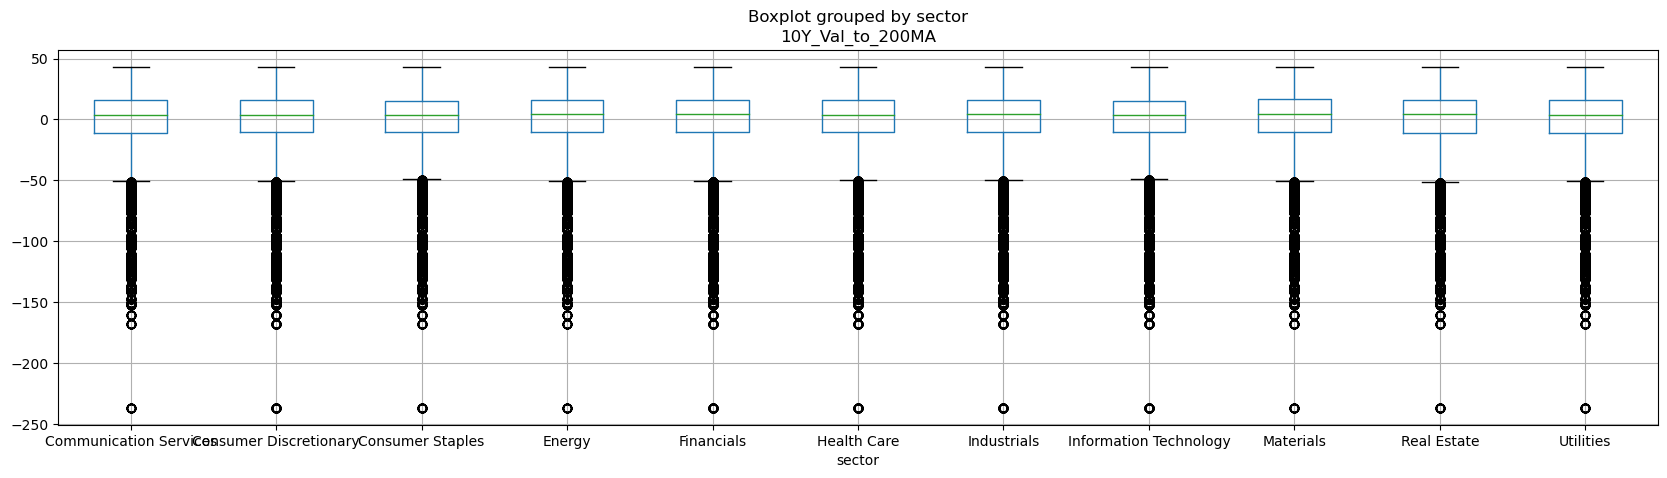

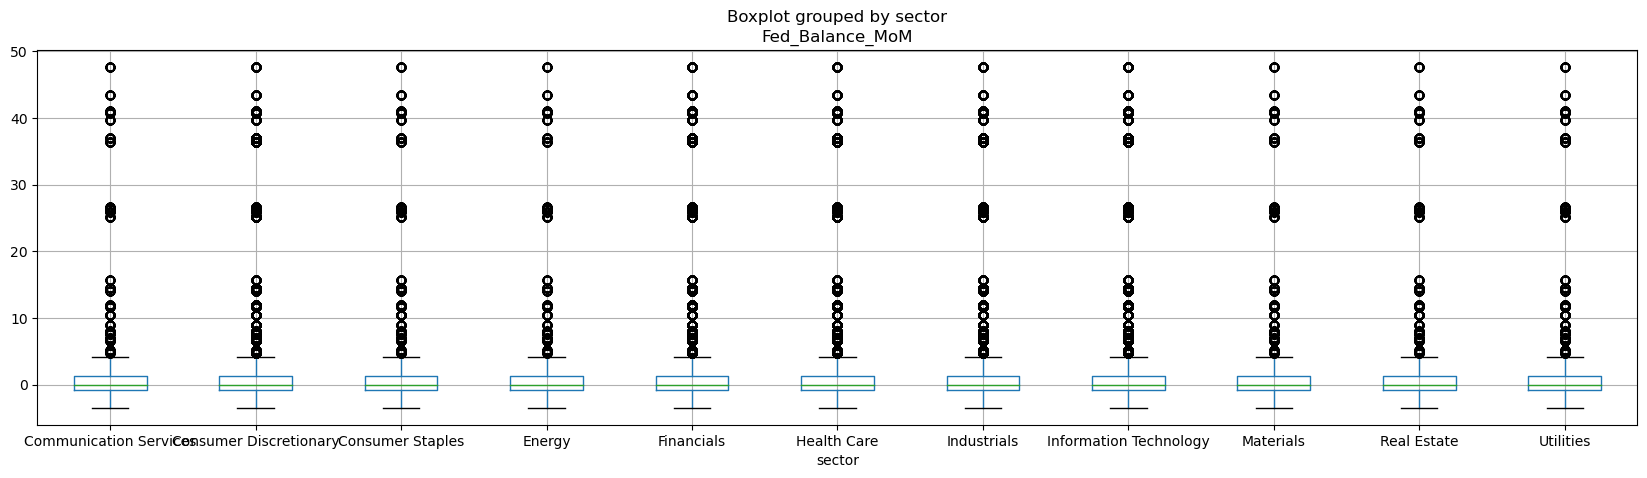

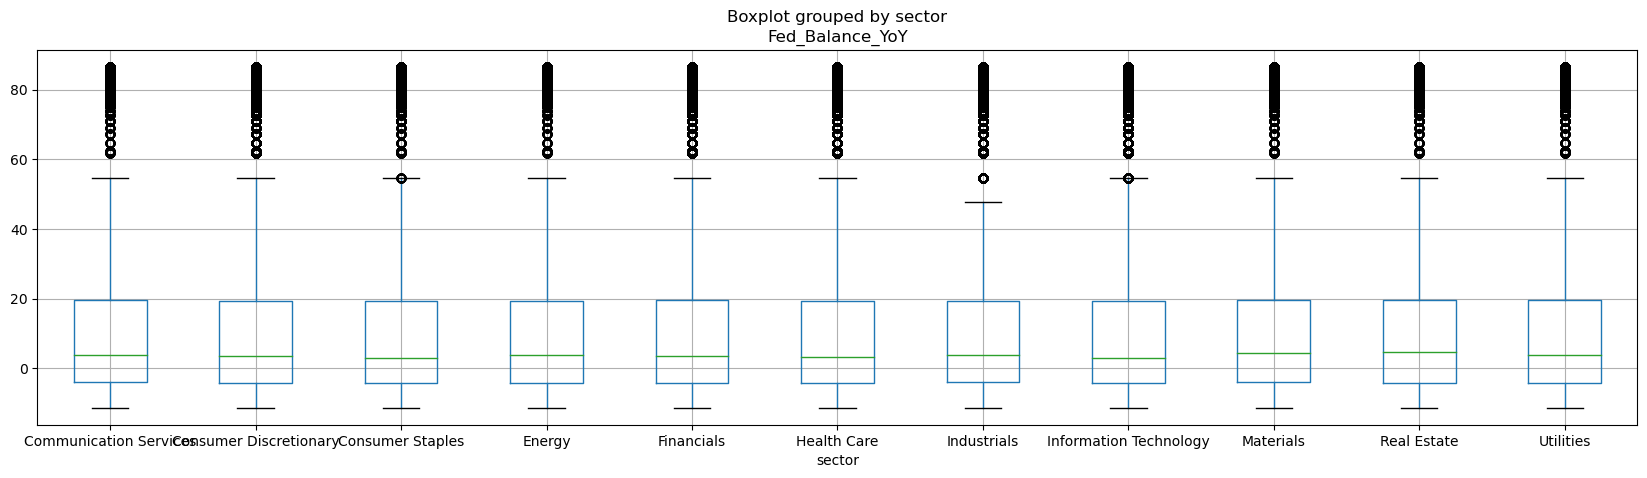

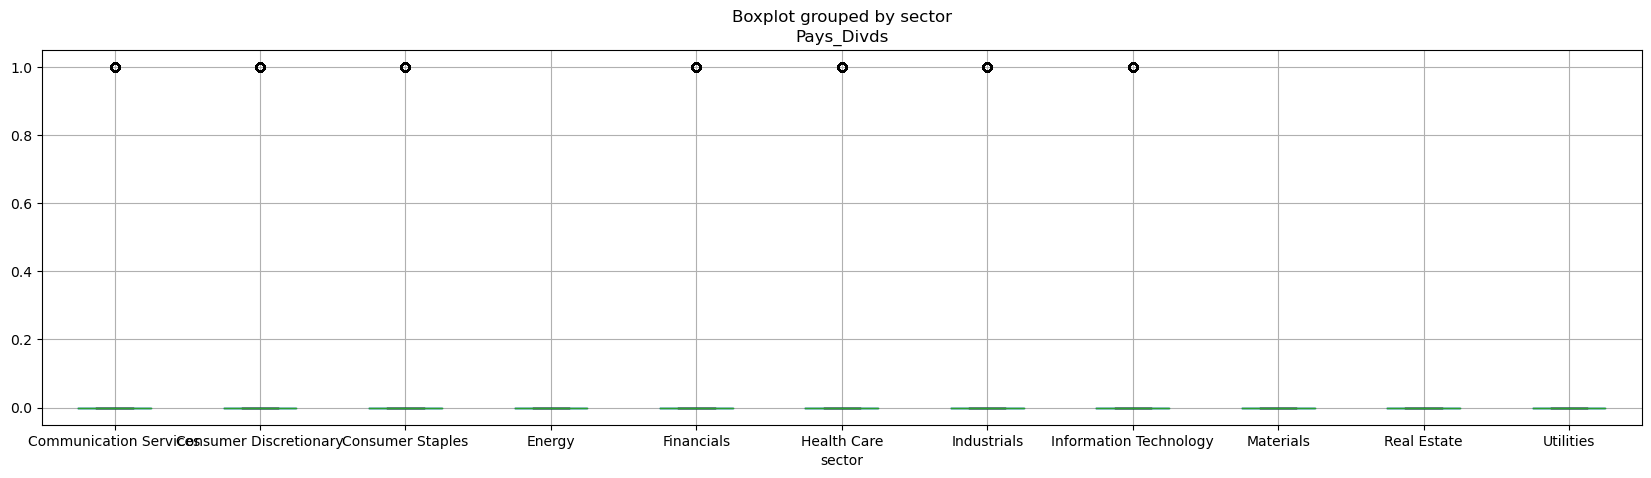

In [29]:
# First we need to select columns that we did not use in outliers replacement
numeric_columns = df_compact.select_dtypes(include='number').columns

def create_box_plots(df, columns, by = None, height = 20, width = 10):
    fig, axes = plt.subplots(nrows=len(columns)//2, ncols=2, figsize = (height,width)) # create 2x2 array of subplots

    j = 0
    for col_num, col in enumerate(columns):
        if (col_num % 2) != 0:
            j+=1
        else:
            j = 0
        if by == None:
            df.boxplot(column=col, ax=axes[col_num //2 ,j], figsize = (3,10)); # add boxplot to 1st subplot
        else:
            df.boxplot(column=col, ax=axes[col_num //2 ,j], by = by, figsize = (3,10));

    plt.show()

#create_box_plots(df_train, numeric_columns, "sector", 20,60)
for col in numeric_columns:
    df_compact.boxplot(column=col, by = "sector", figsize = (20,5))

In [ ]:
dfgdfg

We risk to loose about 1.5-2% of the data dealing with outliers. We can go ahead and remove outliers

 ## Let's check the data for skewness

We won't treat data for skeweness

In [ ]:
df_compact.to_csv("full_cleaned_dataframe_2023.csv", index = False, header = True)